(awkward_binning)=
# Estimating parameters of a distribution from awkwardly binned data
:::{post} Oct 23, 2021
:tags: binned data, case study, parameter estimation
:category: intermediate
:author: Eric Ma, Benjamin T. Vincent
:::

## The problem
Let us say that we are interested in inferring the properties of a population. This could be anything from the distribution of age, or income, or body mass index, or a whole range of different possible measures. In completing this task, we might often come across the situation where we have multiple datasets, each of which can inform our beliefs about the overall population.

Very often this data can be in a form that we, as data scientists, would not consider ideal. For example, this data may have been binned into categories. One reason why this is not ideal is that this binning process actually discards information - we lose any knowledge about where in a certain bin an individual datum lies. A second reason why this is not ideal is that different studies may use alternative binning methods - for example one study might record age in terms of decades (e.g. is someone in their 20's, 30's, 40's and so on) but another study may record age (indirectly) by assigning generational labels (Gen Z, Millennial, Gen X, Boomer II, Boomer I, Post War) for example.

So we are faced with a problem: we have datasets with counts of our measure of interest (whether that be age, income, BMI, or whatever), but they are binned, and they have been binned _differently_. This notebook presents a solution to this problem that [PyMC Labs](https://www.pymc-labs.io) worked on, supported by the [Gates Foundation](https://www.gatesfoundation.org/). We _can_ make inferences about the parameters of a population level distribution.

![](gates.png)

## The solution

More formally, we describe the problem as: if we have the bin edges (aka cut points) used for data binning, and bin counts, how can we estimate the parameters of the underlying distribution? We will present a solution and various illustrative examples of this solution, which makes the following assumptions:

1. that the bins are order-able (e.g. underweight, normal, overweight, obese),
2. the underlying distribution is specified in a parametric form, and
3. the cut points that delineate the bins are known and can be pinpointed on the support of the distribution (also known as the valid values that the probability distribution can return).

The approach used is heavily based upon the logic behind [ordinal regression](https://en.wikipedia.org/wiki/Ordinal_regression). This approach proposes that observed bin counts $Y = {1, 2, \ldots, K}$ are generated from a set of bin edges (aka cutpoints) $\theta_1, \ldots, \theta _{K-1}$ operating upon a latent probability distribution which we could call $y^*$. We can describe the probability of observing data in bin 1 as:

$$P(Y=1) = \Phi(\theta_1) - \Phi(-\infty) = \Phi(\theta_1) - 0$$

bin 2 as:

$$P(Y=2) = \Phi(\theta_2) - \Phi(\theta_1)$$

bin 3 as:

$$P(Y=3) = \Phi(\theta_3) - \Phi(\theta_2)$$

and bin 4 as:

$$P(Y=4) = \Phi(\infty) - \Phi(\theta_3) = 1 - \Phi(\theta_3)$$

where $\Phi$ is the standard cumulative normal.

![](ordinal.png)

In ordinal regression, the cutpoints are treated as latent variables and the parameters of the normal distribution may be treated as observed (or derived from other predictor variables). This problem differs in that:

- the parameters of the Gaussian are _unknown_, 
- we do not want to be confined to the Gaussian distribution,
- we have observed an array of `cutpoints`,
- we have observed bin `counts`, 

We are now in a position to sketch out a generative PyMC model:

```python
import aesara.tensor as at

with pm.Model() as model:
    # priors
    mu = pm.Normal("mu")
    sigma = pm.HalfNormal("sigma")
    # generative process
    probs = pm.math.exp(pm.logcdf(pm.Normal.dist(mu=mu, sigma=sigma), cutpoints))
    probs = pm.math.concatenate([[0], probs, [1]])
    probs = at.extra_ops.diff(probs)
    # likelihood
    pm.Multinomial("counts", p=probs, n=sum(counts), observed=counts)
```

The exact way we implement the models below differs only very slightly from this, but let's decompose how this works.
Firstly we define priors over the `mu` and `sigma` parameters of the latent distribution. Then we have 3 lines which calculate the probability that any observed datum falls in a given bin. The first line of this
```python
probs = pm.math.exp(pm.logcdf(pm.Normal.dist(mu=mu, sigma=sigma), cutpoints))
```
calculates the cumulative density at each of the cutpoints. The second line 
```python
probs = pm.math.concatenate([[0], probs, [1]])
```
simply concatenates the cumulative density at $-\infty$ (which is zero) and at $\infty$ (which is 1).
The third line
```python
probs = at.extra_ops.diff(probs)
```
calculates the difference between consecutive cumulative densities to give the actual probability of a datum falling in any given bin.

Finally, we end with the Multinomial likelihood which tells us the likelihood of observing the `counts` given the set of bin `probs` and the total number of observations `sum(counts)`.

Hypothetically we could have used base python, or numpy, to describe the generative process. The problem with this however is that gradient information is lost, and so completing these operations using numerical libraries which retain gradient information allows this to be used by the MCMC sampling algorithms.

The approach was illustrated with a Gaussian distribution, and below we show a number of worked examples using Gaussian distributions. However, the approach is general, and at the end of the notebook we provide a demonstration that the approach does indeed extend to non-Gaussian distributions.

In [1]:
import warnings

import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

warnings.filterwarnings(action="ignore", category=UserWarning)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({"font.size": 14})
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

## Simulated data with a Gaussian distribution

The first few examples will be based on 2 hypothetical studies which measure a Gaussian distributed variable. Each study will have it's own sample size, and our task is to learn the parameters of the population level Gaussian distribution. Frustration 1 is that the data have been binned. Frustration 2 is that each study has used different categories, that is, different cutpoints in this data binning process.

In this simulation approach, we will define the true population level parameters as:
- `true_mu`: -2.0
- `true_sigma`: 2.0

Our goal will be to recover the `mu` and `sigma` values given only the bin counts and cutpoints.

In [3]:
# Generate two different sets of random samples from the same Gaussian.
true_mu, true_sigma = -2, 2
x1 = rng.normal(loc=true_mu, scale=true_sigma, size=1500)
x2 = rng.normal(loc=true_mu, scale=true_sigma, size=2000)

The studies used the following, different, cutpoints for their data binning process.

In [4]:
# First discretization (cutpoints)
d1 = np.array([-2.0, -1.0, 0.0, 1.0, 2.0])
# Second discretization (cutpoints)
d2 = np.array([-5.0, -3.5, -2.0, -0.5, 1.0, 2.5])

In [5]:
def data_to_bincounts(data, cutpoints):
    # categorise each datum into correct bin
    bins = np.digitize(data, bins=cutpoints)
    # bin counts
    counts = pd.DataFrame({"bins": bins}).groupby(by="bins")["bins"].agg("count")
    return counts


c1 = data_to_bincounts(x1, d1)
c2 = data_to_bincounts(x2, d2)

Let's visualise this in one convenient figure. The left hand column shows the underlying data and the cutpoints for both studies. The right hand column shows the resulting bin counts.

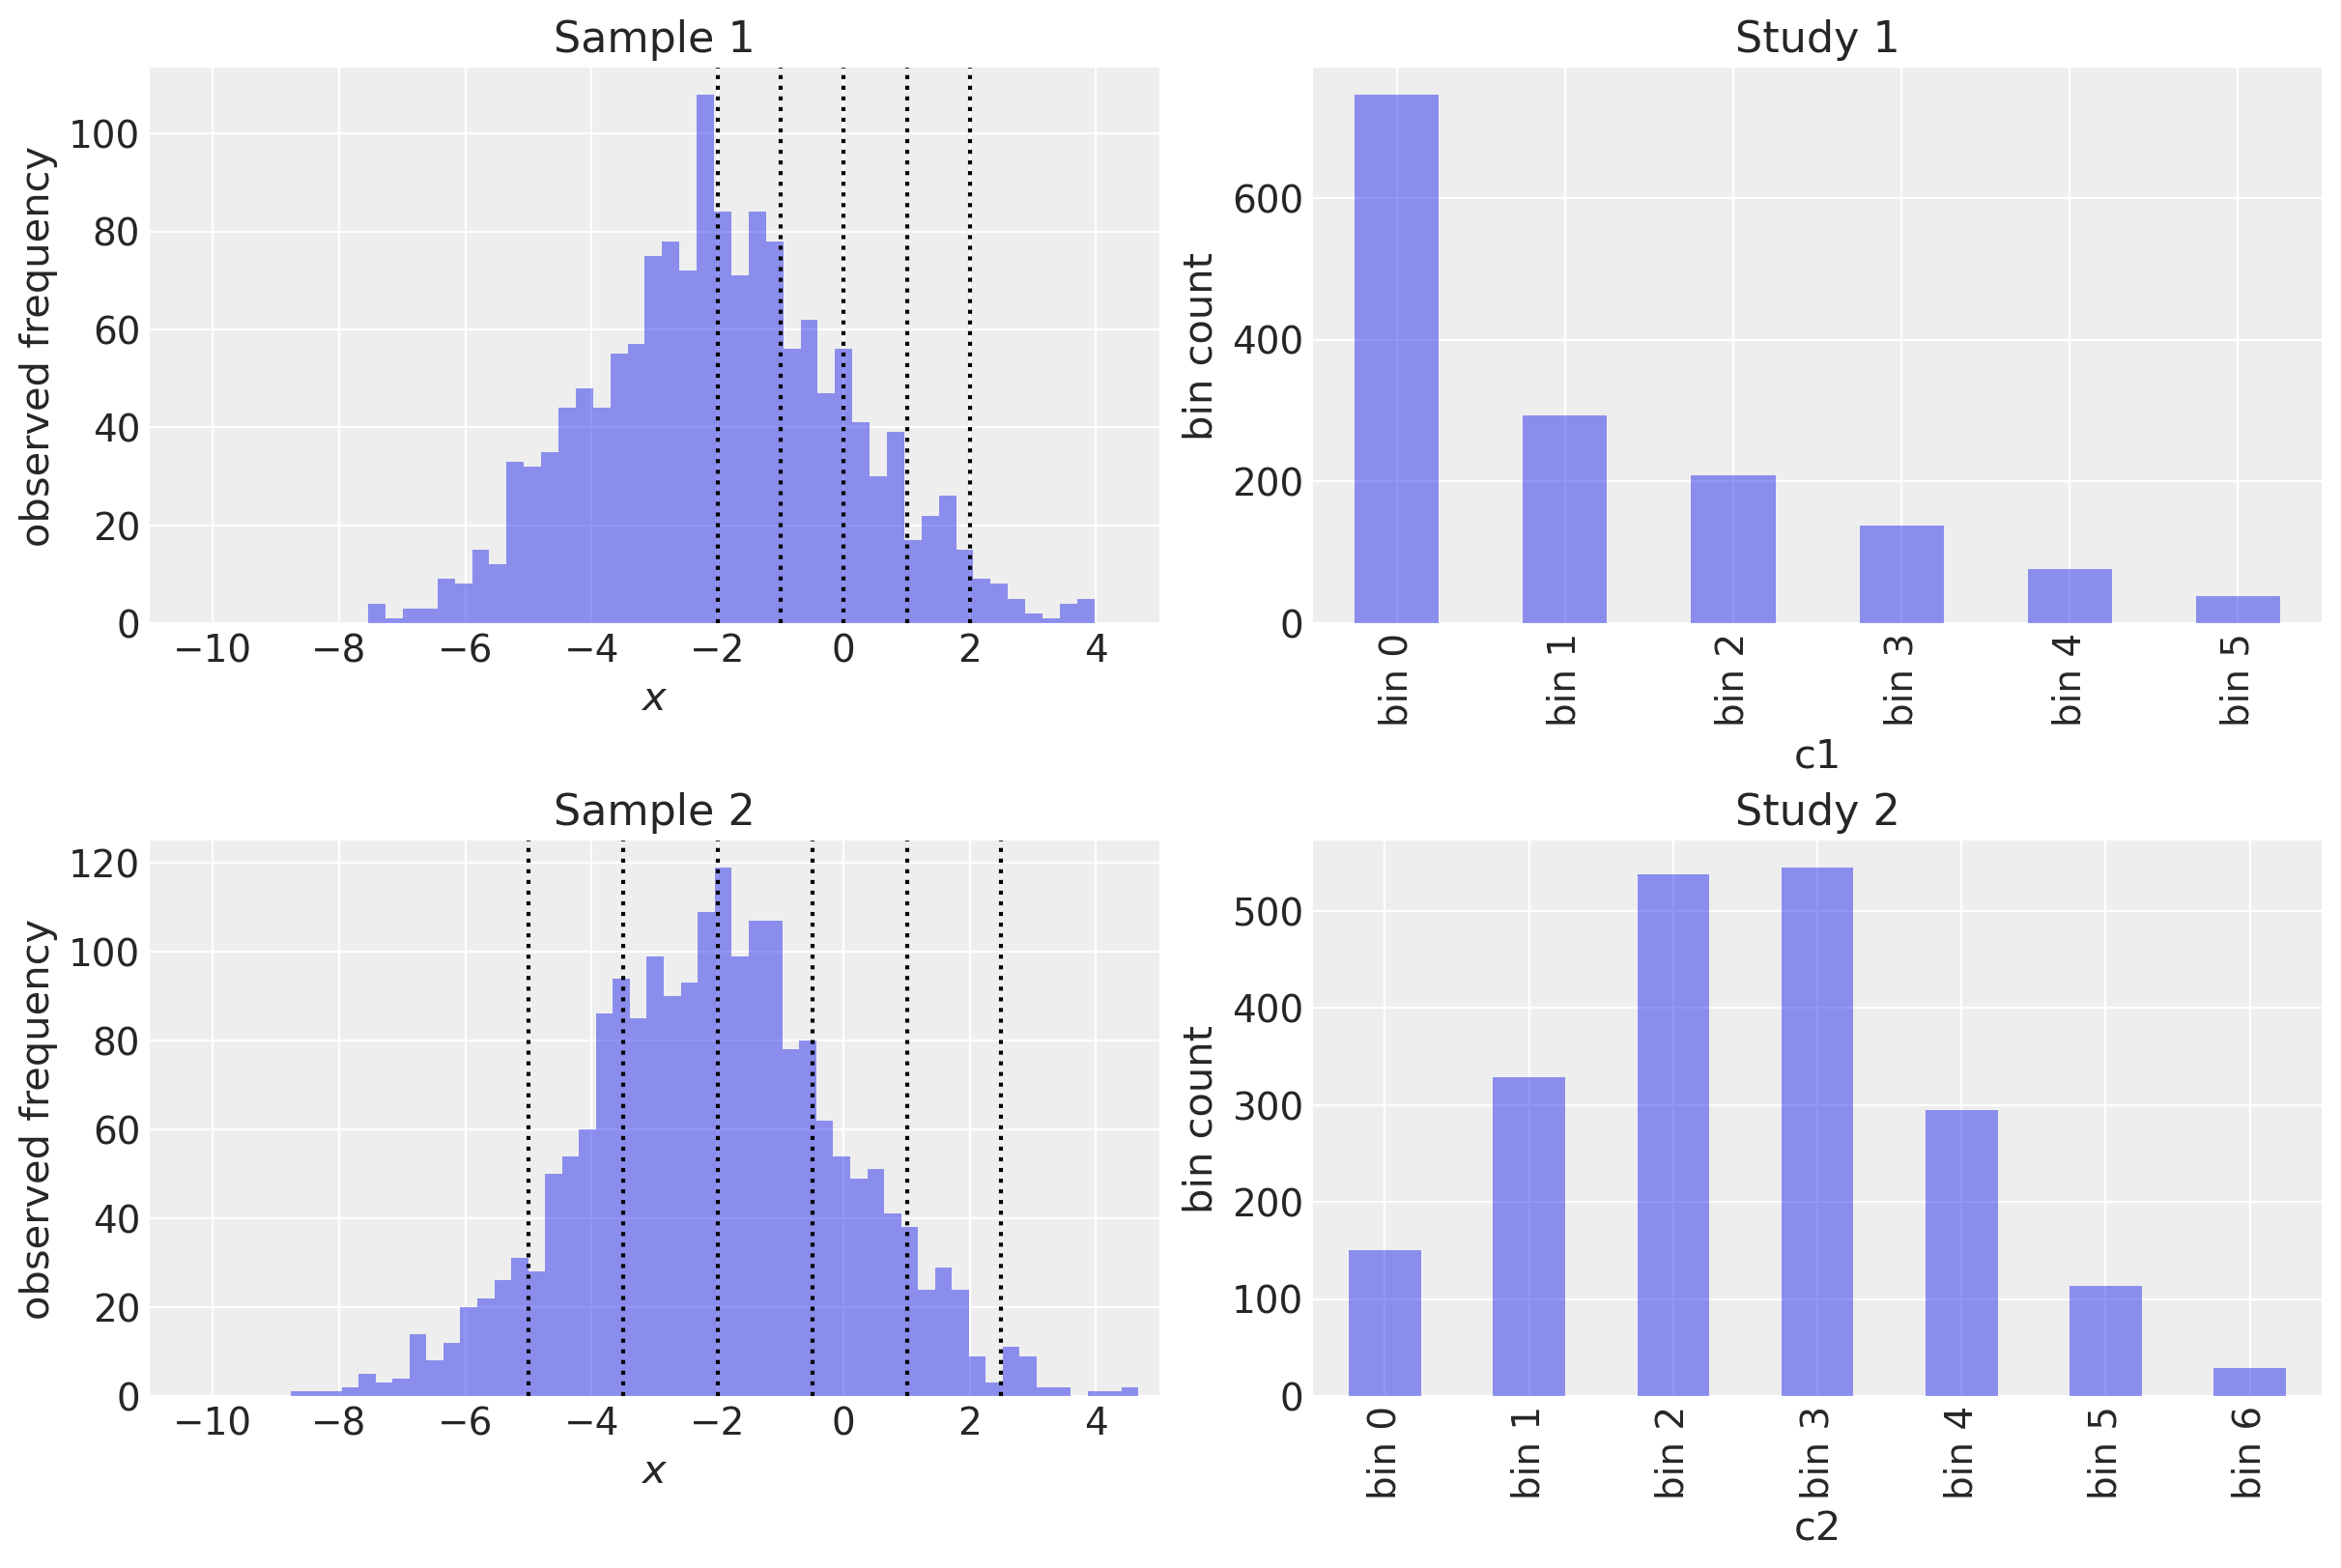

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# First set of measurements
ax[0, 0].hist(x1, 50, alpha=0.5)

for cut in d1:
    ax[0, 0].axvline(cut, color="k", ls=":")

# Plot observed bin counts
c1.plot(kind="bar", ax=ax[0, 1], alpha=0.5)
ax[0, 1].set_xticklabels([f"bin {n}" for n in range(len(c1))])
ax[0, 1].set(title="Study 1", xlabel="c1", ylabel="bin count")

# Second set of measuremsnts
ax[1, 0].hist(x2, 50, alpha=0.5)

for cut in d2:
    ax[1, 0].axvline(cut, color="k", ls=":")

# Plot observed bin counts
c2.plot(kind="bar", ax=ax[1, 1], alpha=0.5)
ax[1, 1].set_xticklabels([f"bin {n}" for n in range(len(c2))])
ax[1, 1].set(title="Study 2", xlabel="c2", ylabel="bin count")

# format axes
ax[0, 0].set(xlim=(-11, 5), xlabel="$x$", ylabel="observed frequency", title="Sample 1")
ax[1, 0].set(xlim=(-11, 5), xlabel="$x$", ylabel="observed frequency", title="Sample 2");

Each bin is paired with counts.
As you'll see above,
`c1` and `c2` are binned differently.
One has 6 bins, the other has 7.
`c1` omits basically half of the Gaussian distribution.

To recap, in a real situation we might have access to the cutpoints and to the bin counts, but _not_ the underlying data `x1` or `x2`.

## Example 1: Gaussian parameter estimation with one set of bins

We will start by investigating what happens when we use only one set of bins to estimate the `mu` and `sigma` parameter.

### Model specification

In [7]:
with pm.Model() as model1:
    sigma = pm.HalfNormal("sigma")
    mu = pm.Normal("mu")

    probs1 = pm.math.exp(pm.logcdf(pm.Normal.dist(mu=mu, sigma=sigma), d1))
    probs1 = at.extra_ops.diff(pm.math.concatenate([[0], probs1, [1]]))
    pm.Multinomial("counts1", p=probs1, n=c1.sum(), observed=c1.values)

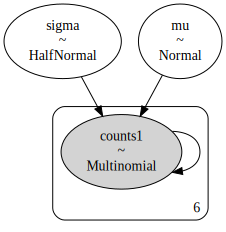

In [8]:
pm.model_to_graphviz(model1)

In [9]:
with model1:
    trace1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


### Checks on model

We first start with posterior predictive checks.
Given the posterior values,
we should be able to generate observations that look close to what we observed.

In [10]:
with model1:
    ppc = pm.sample_posterior_predictive(trace1)

We can do this graphically.

Text(0.5, 1.0, 'Six bin discretization of N(-2, 2)')

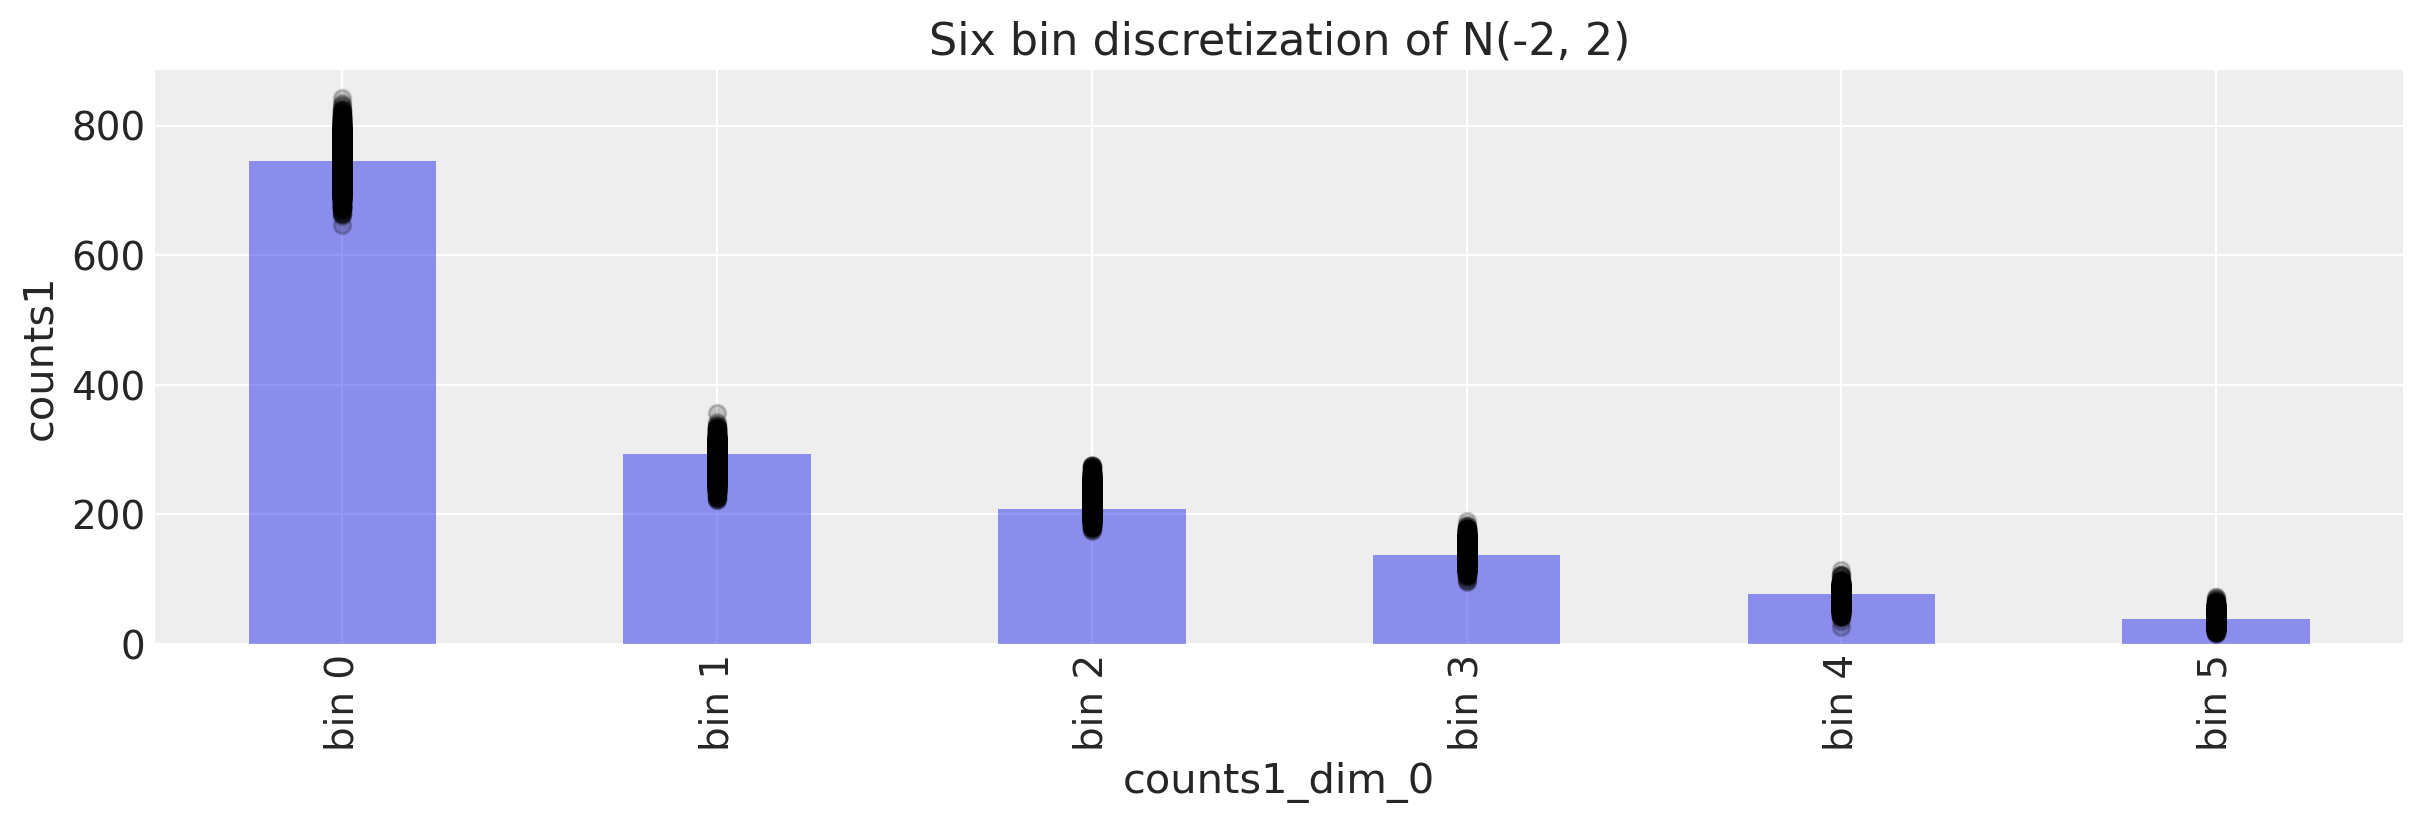

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))
# Plot observed bin counts
c1.plot(kind="bar", ax=ax, alpha=0.5)
# Plot posterior predictive
ppc.posterior_predictive.plot.scatter(x="counts1_dim_0", y="counts1", color="k", alpha=0.2)
# Formatting
ax.set_xticklabels([f"bin {n}" for n in range(len(c1))])
ax.set_title("Six bin discretization of N(-2, 2)")

It looks like the numbers are in the right ballpark.
With the numbers ordered correctly, we also have the correct proportions identified.

We can also get programmatic access to our posterior predictions in a number of ways:

In [12]:
ppc.posterior_predictive.counts1.values

array([[[714, 284, 228, 137,  74,  63],
        [753, 279, 228, 138,  66,  36],
        [734, 304, 222, 141,  60,  39],
        ...,
        [746, 274, 234, 127,  67,  52],
        [719, 290, 237, 150,  67,  37],
        [706, 285, 229, 143,  97,  40]],

       [[773, 263, 211, 149,  61,  43],
        [752, 253, 233, 153,  75,  34],
        [703, 294, 214, 148,  87,  54],
        ...,
        [686, 317, 257, 128,  66,  46],
        [758, 276, 240, 121,  66,  39],
        [755, 258, 221, 151,  62,  53]],

       [[796, 255, 181, 140,  74,  54],
        [764, 267, 224, 120,  83,  42],
        [794, 267, 196, 142,  65,  36],
        ...,
        [767, 263, 220, 129,  78,  43],
        [774, 278, 229, 125,  62,  32],
        [724, 289, 234, 153,  67,  33]],

       [[758, 284, 228, 126,  58,  46],
        [743, 274, 227, 145,  69,  42],
        [755, 299, 212, 119,  71,  44],
        ...,
        [718, 302, 240, 135,  68,  37],
        [722, 286, 217, 155,  78,  42],
        [767, 285, 201

Let's take the mean and compare it against the observed counts:

In [13]:
ppc.posterior_predictive.counts1.mean(dim=["chain", "draw"]).values

array([744.51325, 281.33575, 223.45975, 141.09875,  70.2235 ,  39.369  ])

In [14]:
c1.values

array([746, 293, 208, 138,  77,  38])

### Recovering parameters

The more important question is whether we have recovered the parameters of the distribution or not.
Recall that we used `mu = -2` and `sigma = 2` to generate the data.

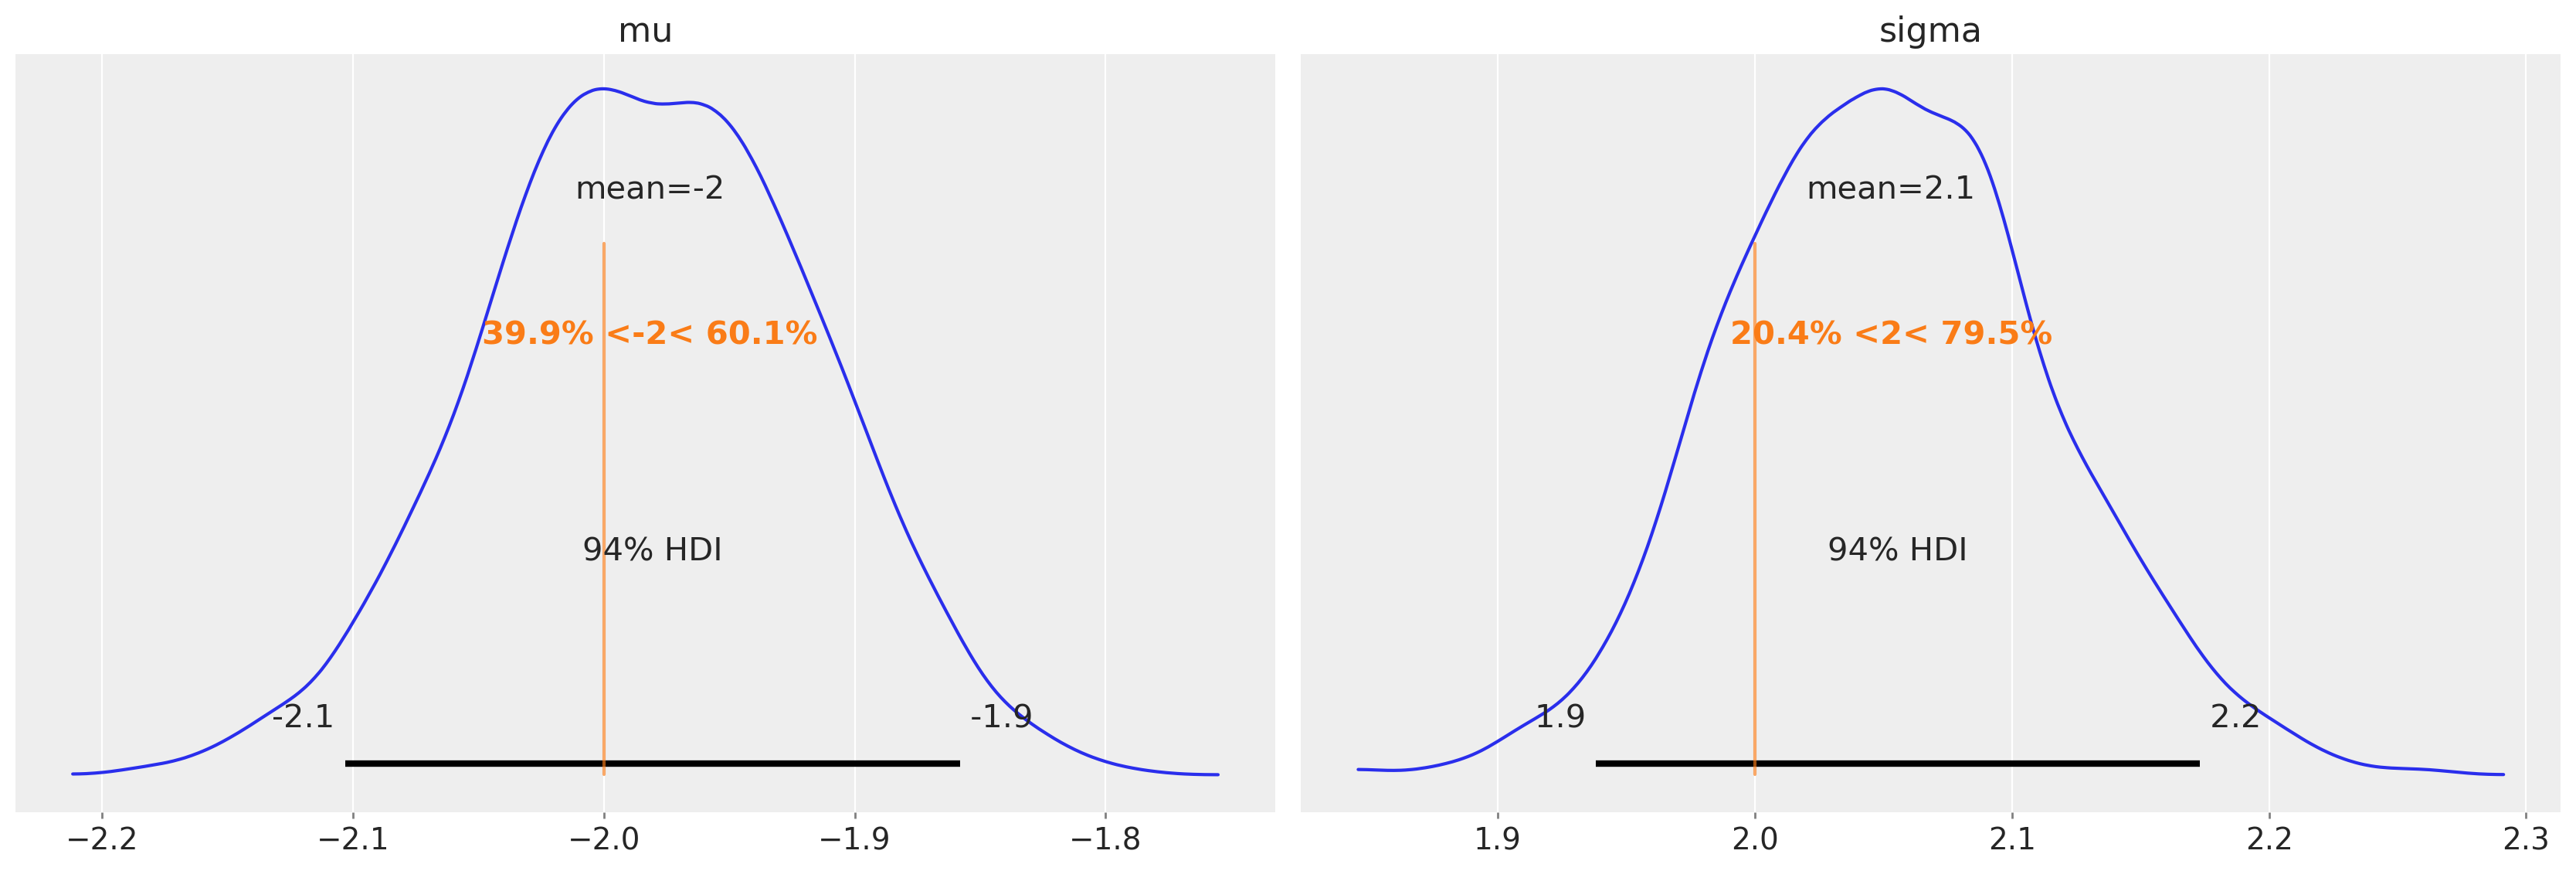

In [15]:
az.plot_posterior(trace1, var_names=["mu", "sigma"], ref_val=[true_mu, true_sigma]);

Pretty good! And we can access the posterior mean estimates (stored as [xarray](http://xarray.pydata.org/en/stable/index.html) types) as below. The MCMC samples arrive back in a 2D matrix with one dimension for the MCMC chain (`chain`), and one for the sample number (`draw`). We can calculate the overal posterior average with `.mean(dim=["draw", "chain"])`.

In [16]:
trace1.posterior["mu"].mean(dim=["draw", "chain"]).values

array(-1.98161385)

In [17]:
trace1.posterior["sigma"].mean(dim=["draw", "chain"]).values

array(2.05300289)

## Example 2: Parameter estimation with the other set of bins

Above, we used one set of binned data. Let's see what happens when we swap out for the other set of data.

### Model specification

As with the above, here's the model specification.

In [18]:
with pm.Model() as model2:
    sigma = pm.HalfNormal("sigma")
    mu = pm.Normal("mu")

    probs2 = pm.math.exp(pm.logcdf(pm.Normal.dist(mu=mu, sigma=sigma), d2))
    probs2 = at.extra_ops.diff(pm.math.concatenate([[0], probs2, [1]]))
    pm.Multinomial("counts2", p=probs2, n=c2.sum(), observed=c2.values)

In [19]:
with model2:
    trace2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


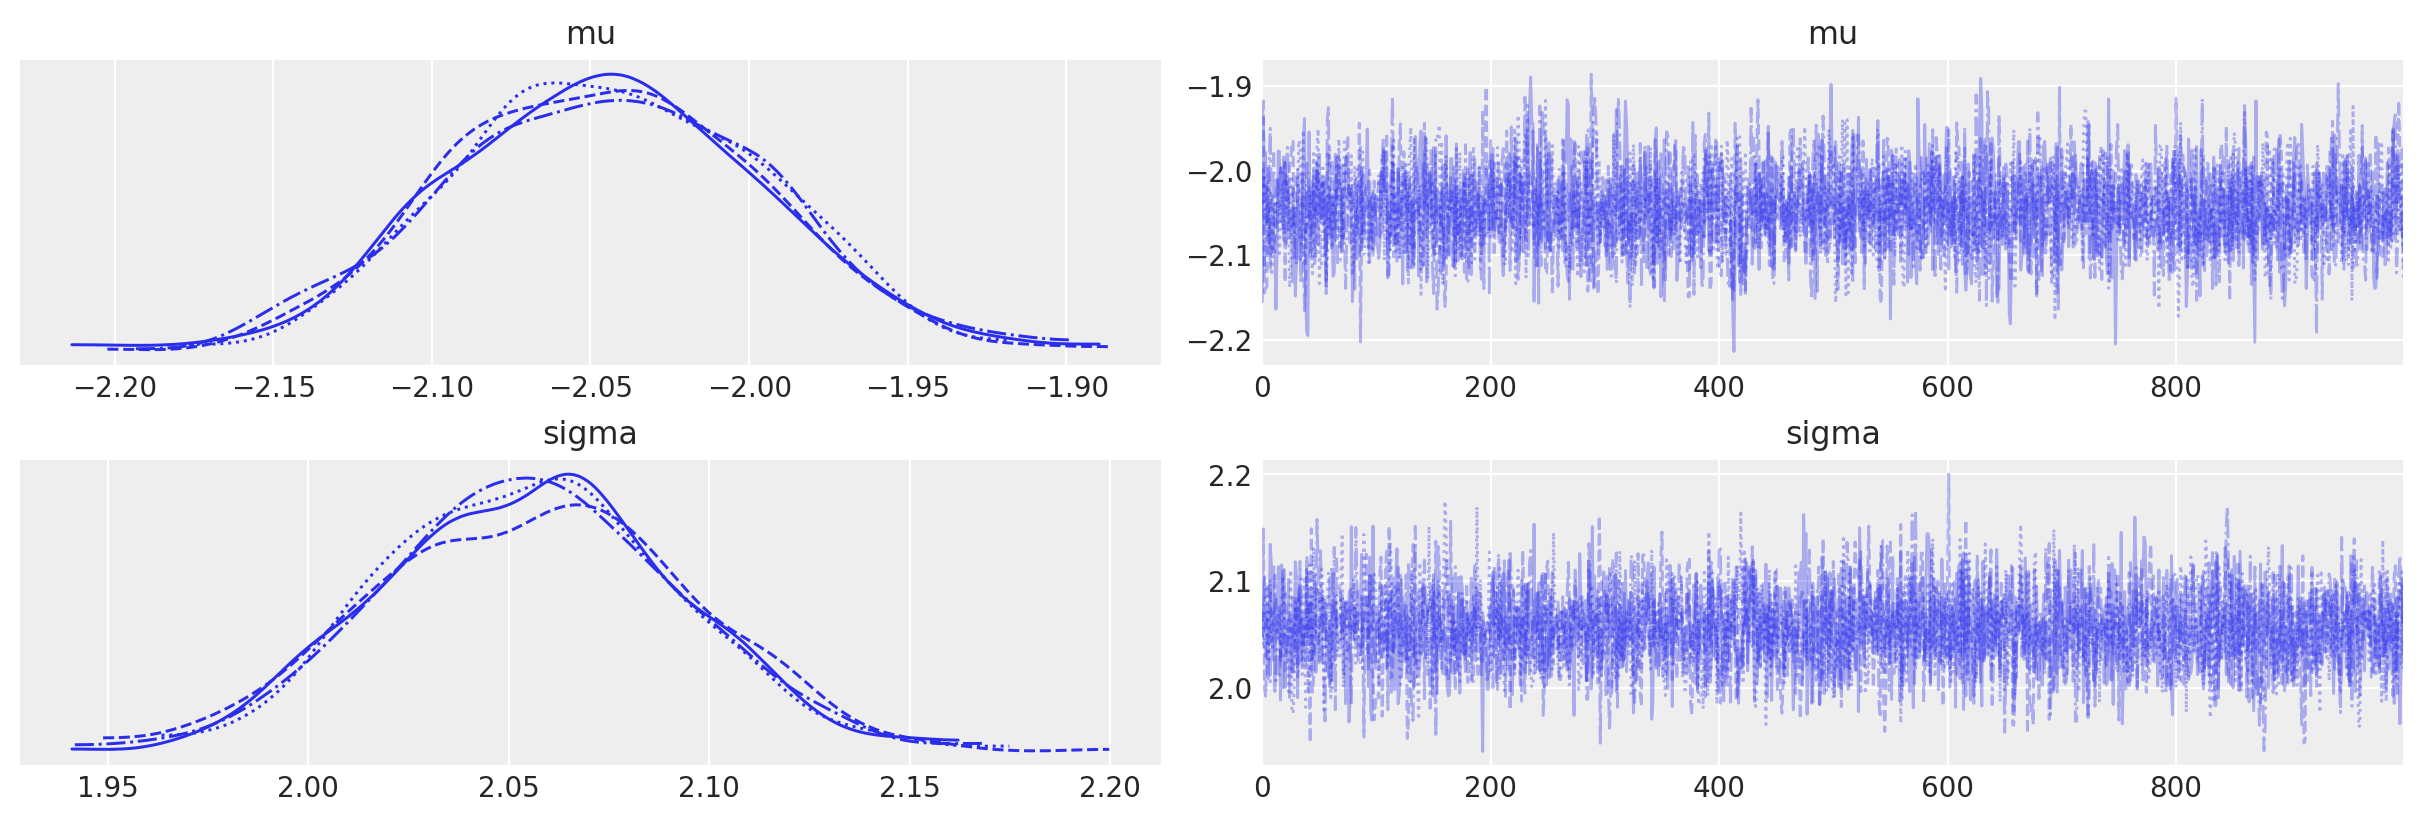

In [20]:
az.plot_trace(trace2);

### Posterior predictive checks

Let's run a PPC check to ensure we are generating data that are similar to what we observed.

In [21]:
with model2:
    ppc = pm.sample_posterior_predictive(trace2)

We calculate the mean bin posterior predictive bin counts, averaged over samples.

In [22]:
ppc.posterior_predictive.counts2.mean(dim=["chain", "draw"]).values

array([150.6875 , 328.46925, 537.65775, 530.53625, 313.99   , 111.5935 ,
        27.06575])

In [23]:
c2.values

array([150, 329, 538, 545, 295, 114,  29])

Looks like a good match. But as always it is wise to visualise things.

Text(0.5, 1.0, 'Seven bin discretization of N(-2, 2)')

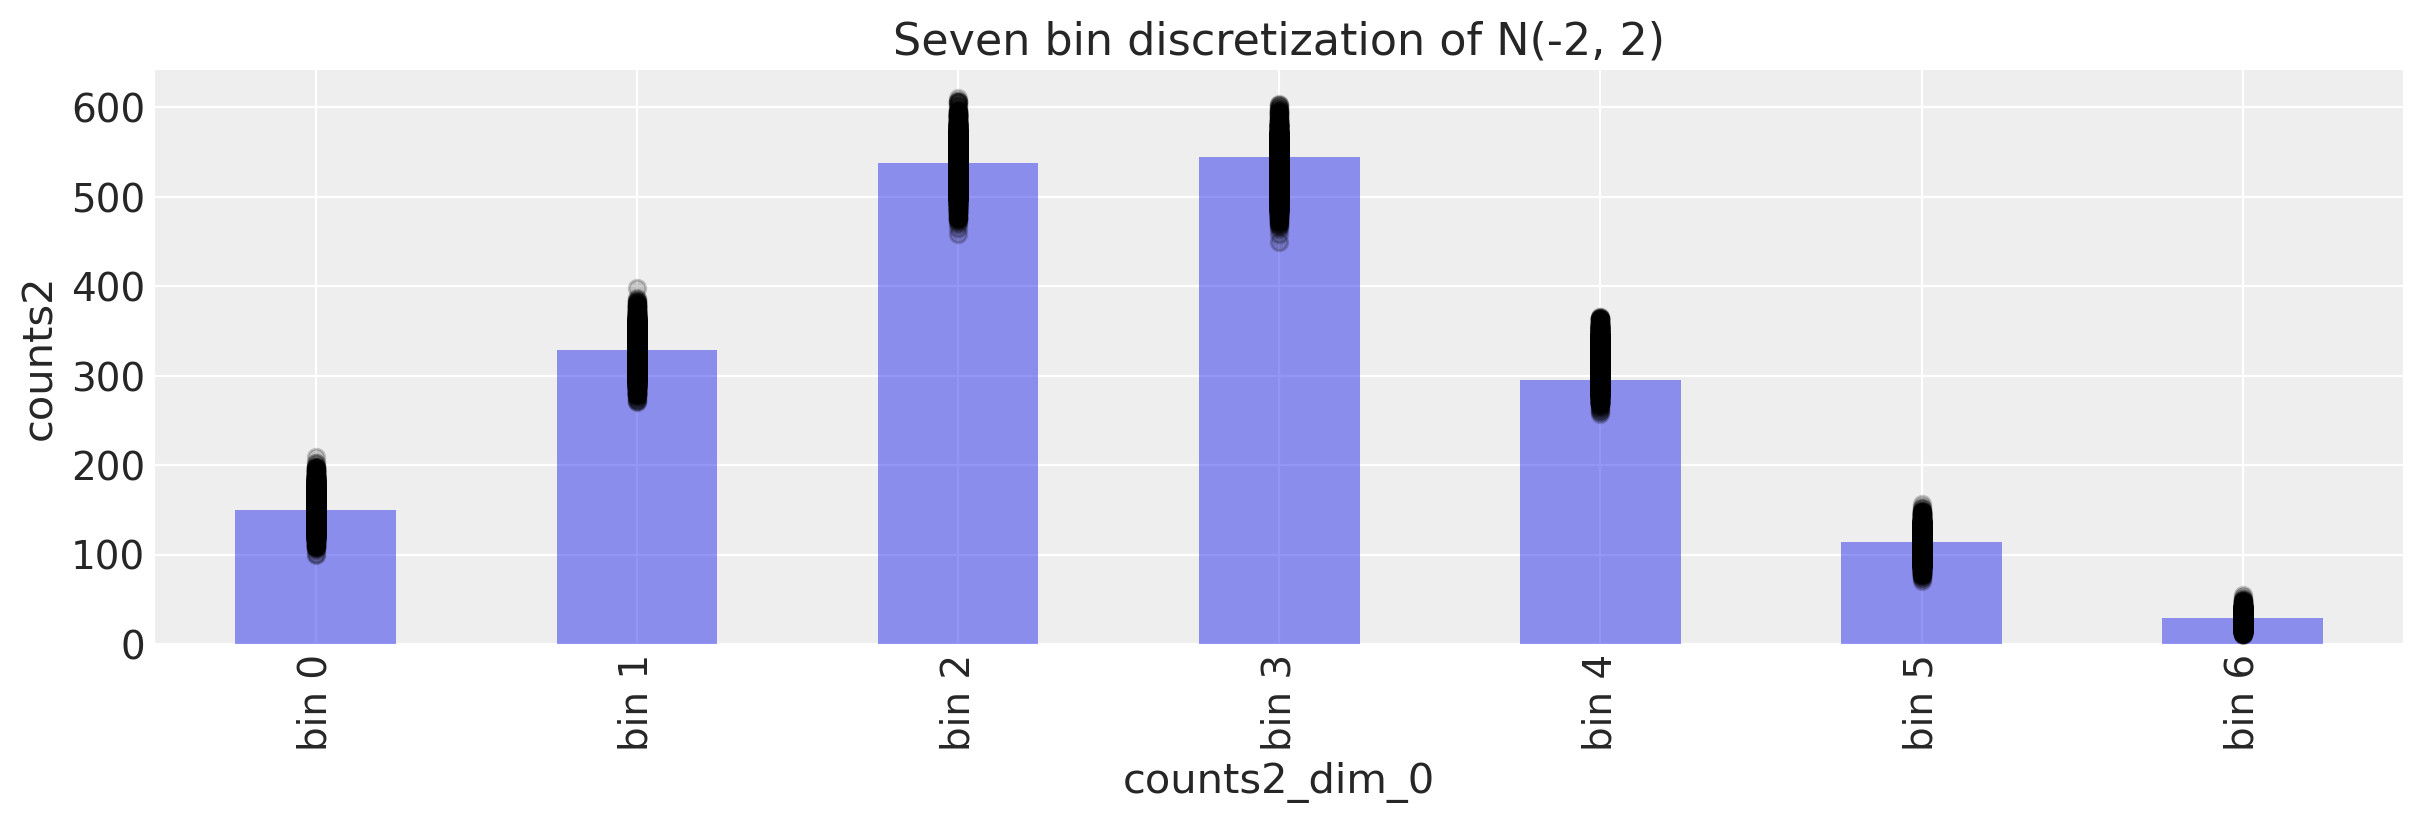

In [24]:
fig, ax = plt.subplots(figsize=(12, 4))
# Plot observed bin counts
c2.plot(kind="bar", ax=ax, alpha=0.5)
# Plot posterior predictive
ppc.posterior_predictive.plot.scatter(x="counts2_dim_0", y="counts2", color="k", alpha=0.2)
# Formatting
ax.set_xticklabels([f"bin {n}" for n in range(len(c2))])
ax.set_title("Seven bin discretization of N(-2, 2)")

Not bad!

### Recovering parameters

And did we recover the parameters?

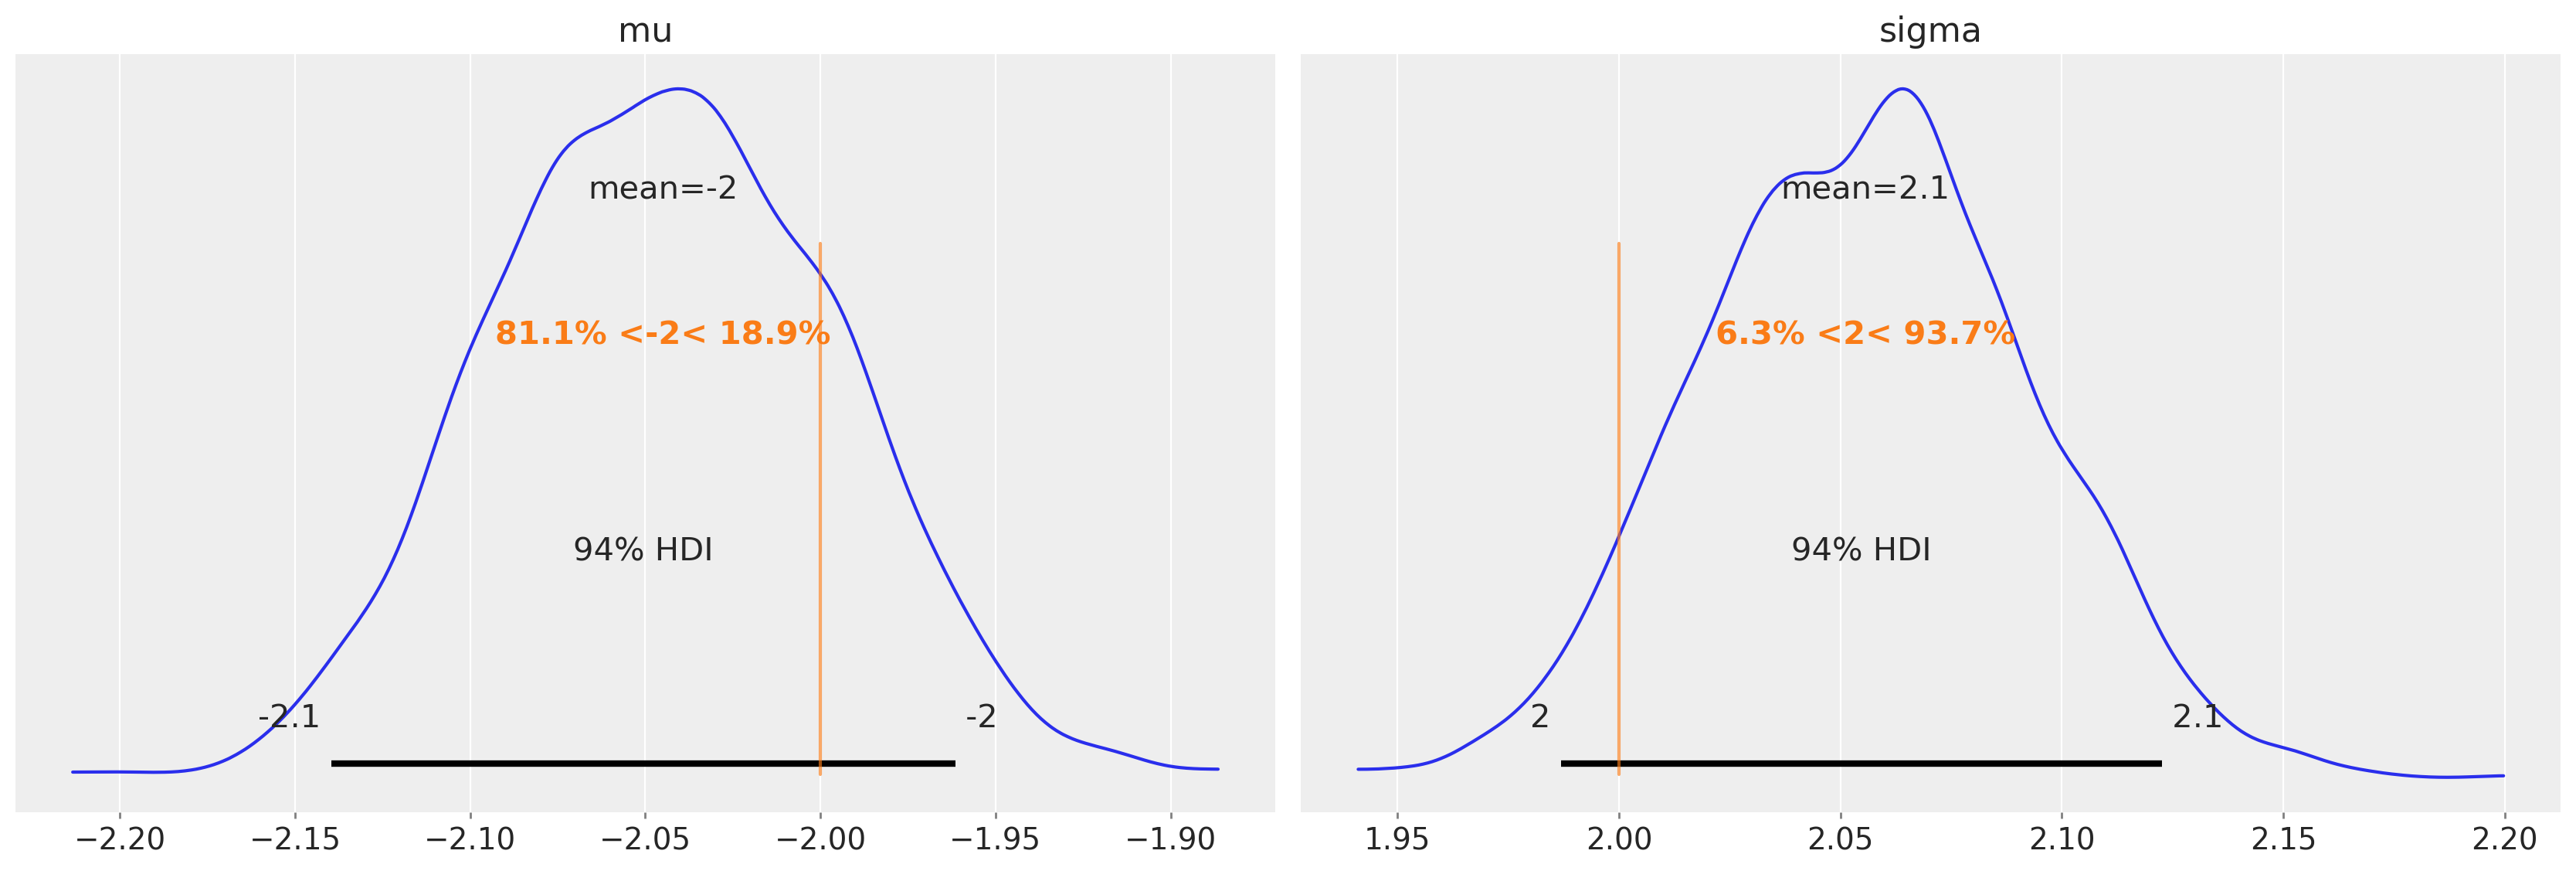

In [25]:
az.plot_posterior(trace2, var_names=["mu", "sigma"], ref_val=[true_mu, true_sigma]);

In [26]:
trace2.posterior["mu"].mean(dim=["draw", "chain"]).values

array(-2.04489232)

In [27]:
trace2.posterior["sigma"].mean(dim=["draw", "chain"]).values

array(2.05560527)

## Example 3: Parameter estimation with two bins together

Now we need to see what happens if we add in both ways of binning.

### Model Specification

In [28]:
with pm.Model() as model3:
    sigma = pm.HalfNormal("sigma")
    mu = pm.Normal("mu")

    probs1 = pm.math.exp(pm.logcdf(pm.Normal.dist(mu=mu, sigma=sigma), d1))
    probs1 = at.extra_ops.diff(pm.math.concatenate([np.array([0]), probs1, np.array([1])]))
    probs1 = pm.Deterministic("normal1_cdf", probs1)

    probs2 = pm.math.exp(pm.logcdf(pm.Normal.dist(mu=mu, sigma=sigma), d2))
    probs2 = at.extra_ops.diff(pm.math.concatenate([np.array([0]), probs2, np.array([1])]))
    probs2 = pm.Deterministic("normal2_cdf", probs2)

    pm.Multinomial("counts1", p=probs1, n=c1.sum(), observed=c1.values)
    pm.Multinomial("counts2", p=probs2, n=c2.sum(), observed=c2.values)

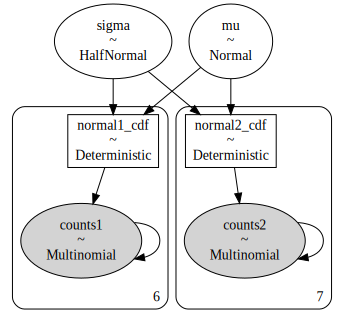

In [29]:
pm.model_to_graphviz(model3)

In [30]:
with model3:
    trace3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


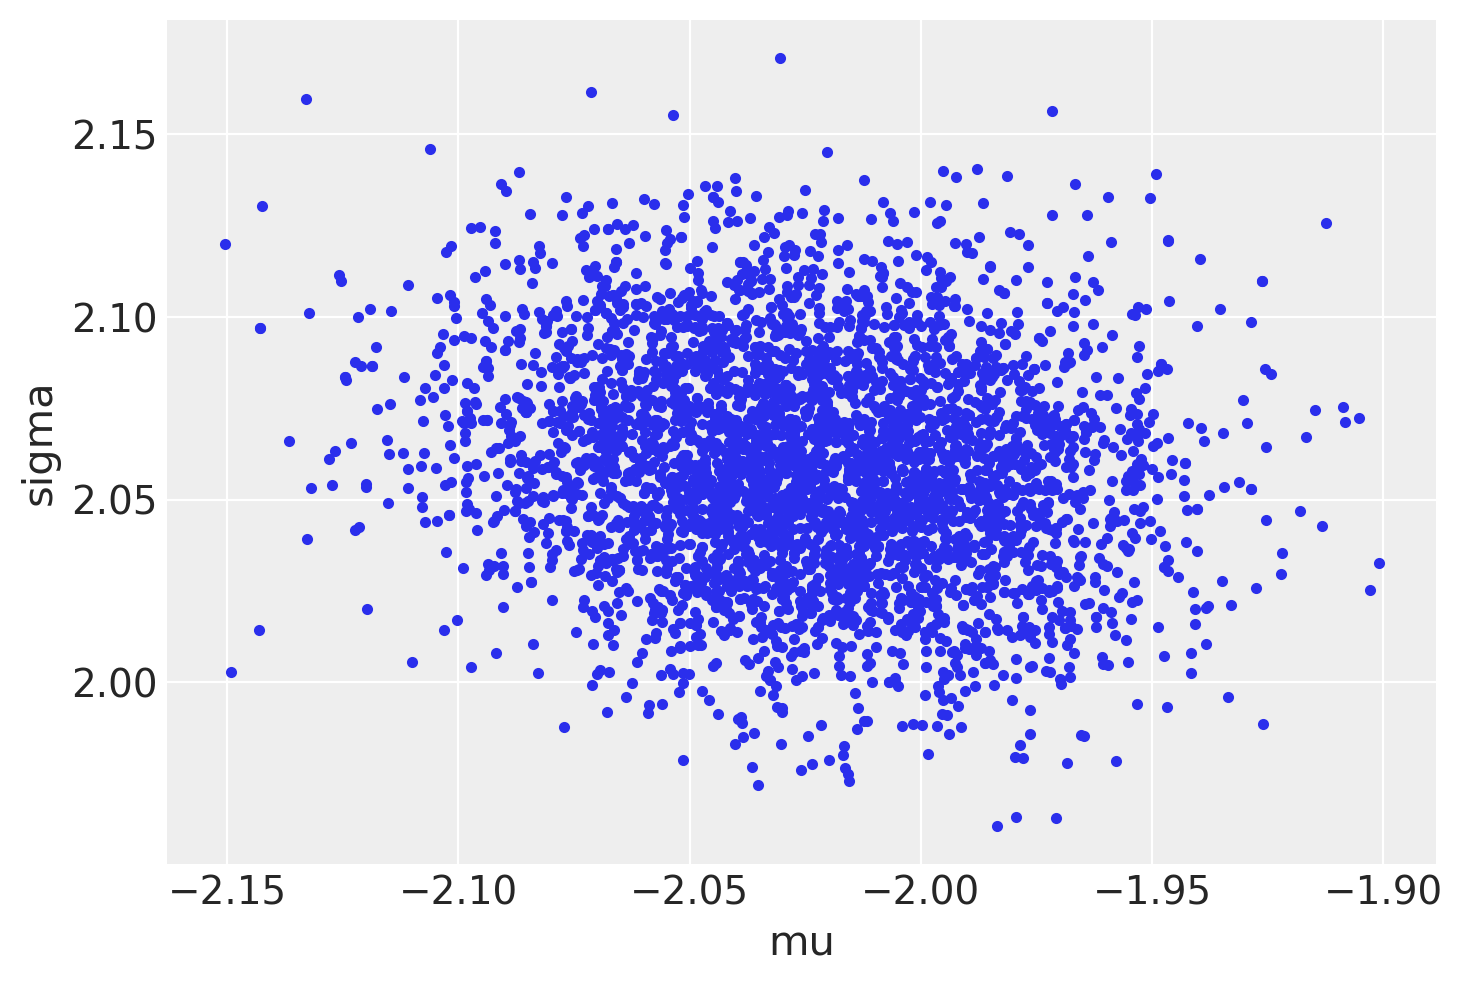

In [31]:
az.plot_pair(trace3, var_names=["mu", "sigma"], divergences=True);

### Posterior predictive checks

In [32]:
with model3:
    ppc = pm.sample_posterior_predictive(trace3)

Text(0.5, 1.0, 'Seven bin discretization of N(-2, 2)')

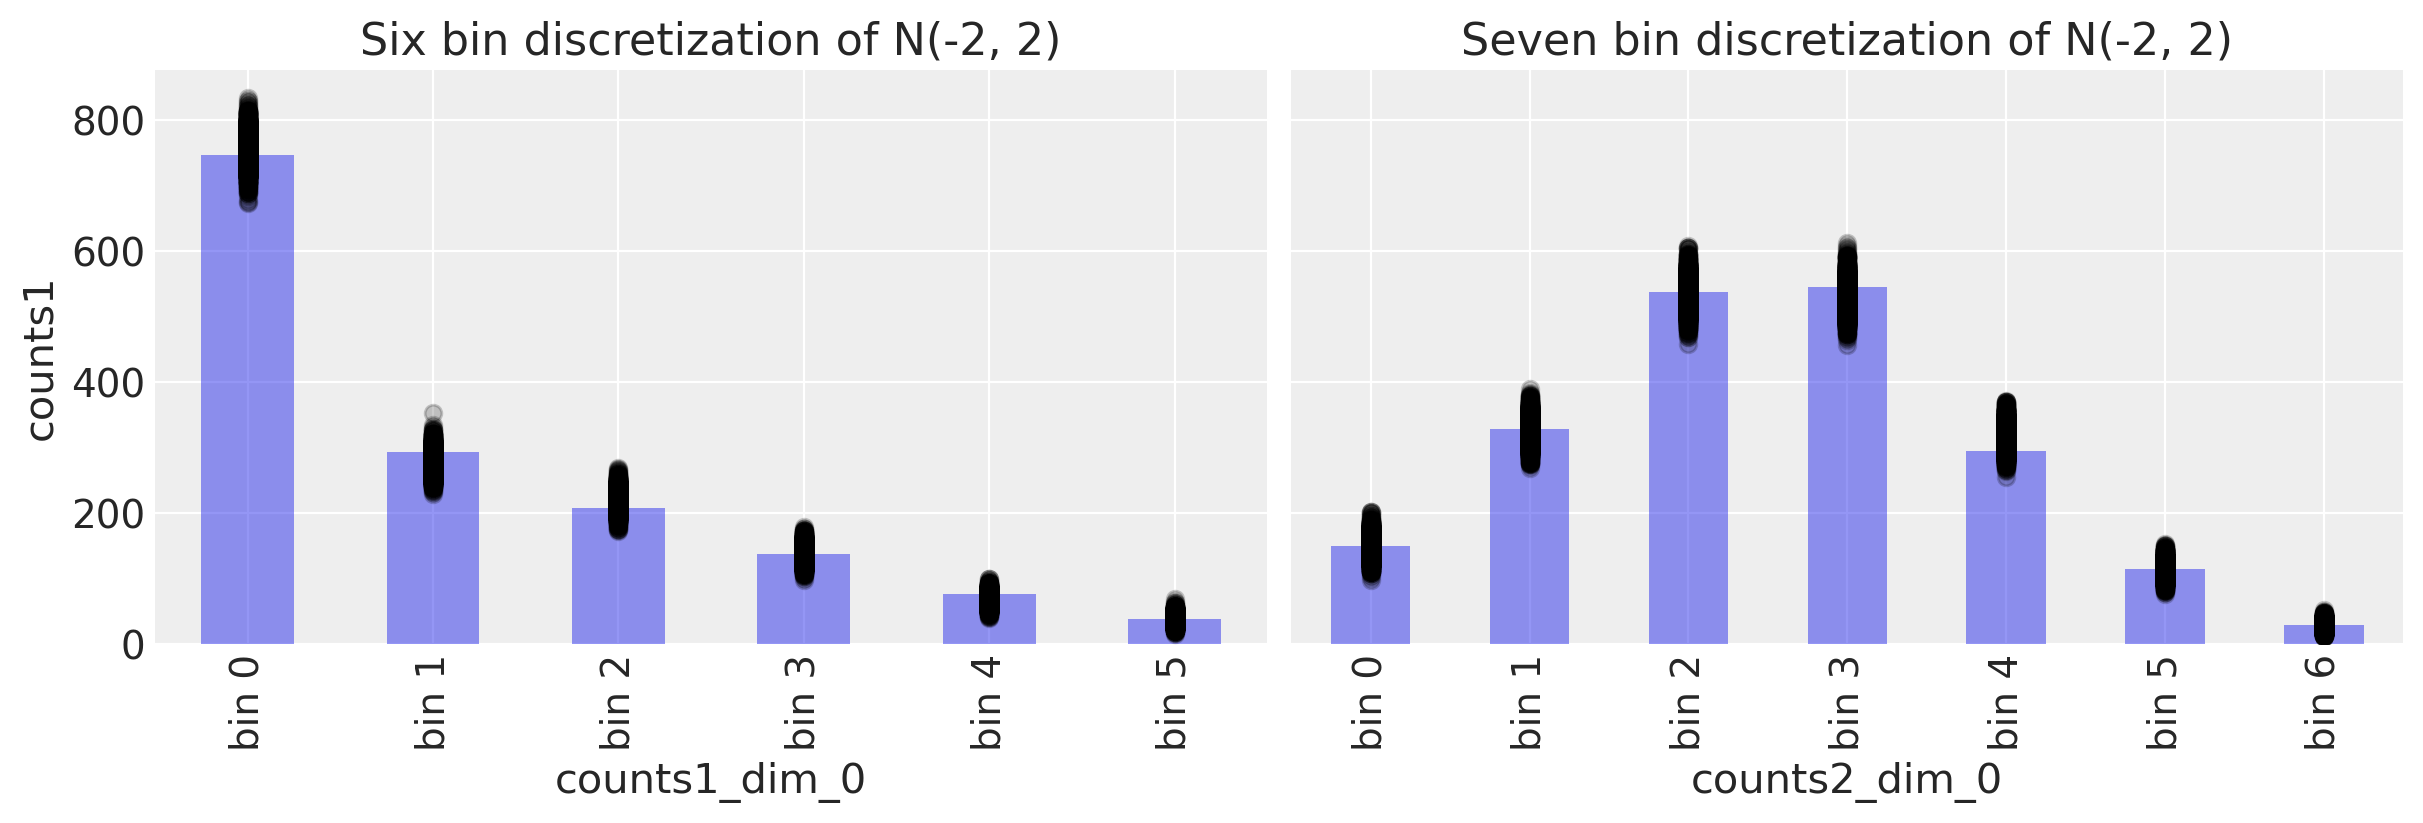

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Study 1 ----------------------------------------------------------------
# Plot observed bin counts
c1.plot(kind="bar", ax=ax[0], alpha=0.5)
# Plot posterior predictive
ppc.posterior_predictive.plot.scatter(
    x="counts1_dim_0", y="counts1", color="k", alpha=0.2, ax=ax[0]
)
# Formatting
ax[0].set_xticklabels([f"bin {n}" for n in range(len(c1))])
ax[0].set_title("Six bin discretization of N(-2, 2)")

# Study 1 ----------------------------------------------------------------
# Plot observed bin counts
c2.plot(kind="bar", ax=ax[1], alpha=0.5)
# Plot posterior predictive
ppc.posterior_predictive.plot.scatter(
    x="counts2_dim_0", y="counts2", color="k", alpha=0.2, ax=ax[1]
)
# Formatting
ax[1].set_xticklabels([f"bin {n}" for n in range(len(c2))])
ax[1].set_title("Seven bin discretization of N(-2, 2)")

### Recovering parameters

In [34]:
trace3.posterior["mu"].mean(dim=["draw", "chain"]).values

array(-2.02455161)

In [35]:
trace3.posterior["sigma"].mean(dim=["draw", "chain"]).values

array(2.05959445)

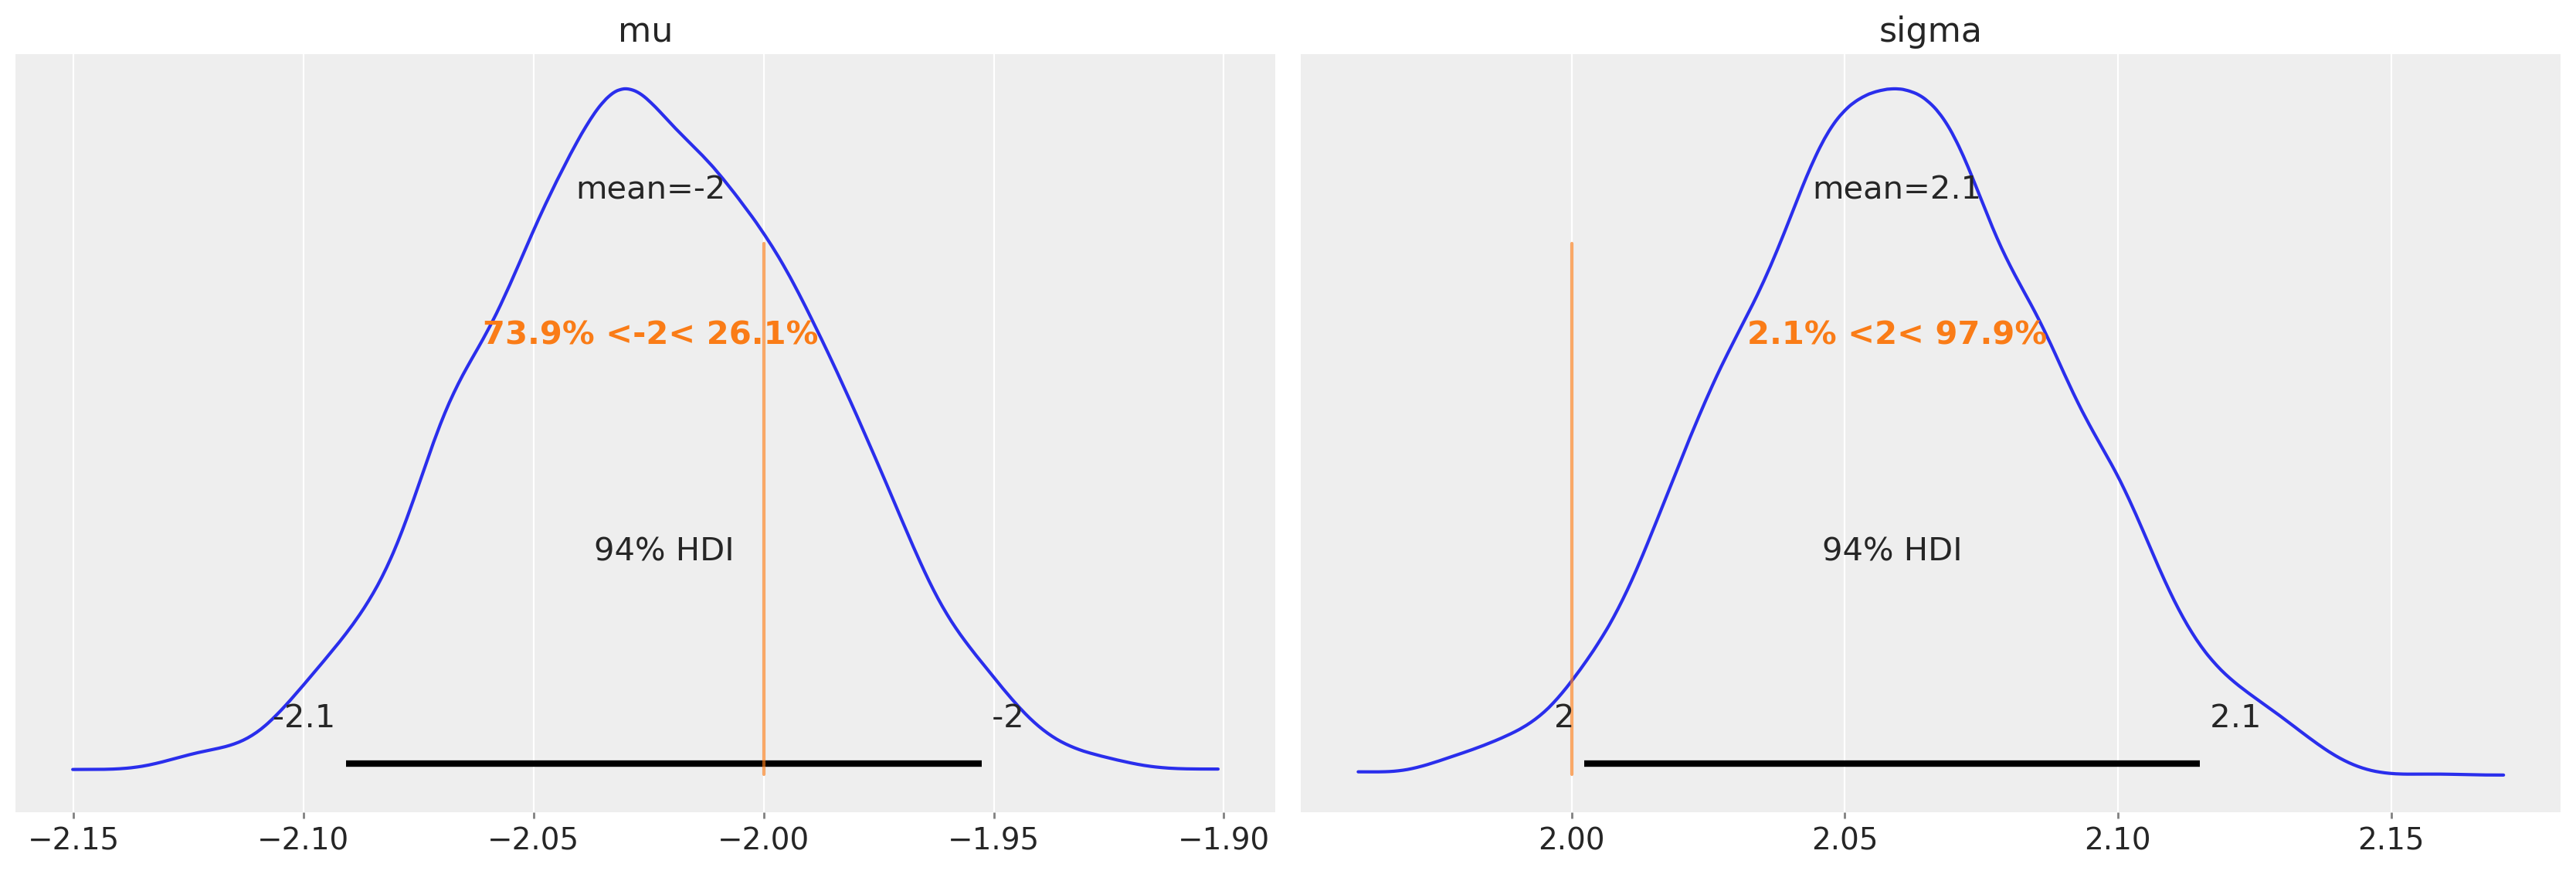

In [36]:
az.plot_posterior(trace3, var_names=["mu", "sigma"], ref_val=[true_mu, true_sigma]);

## Example 4: Parameter estimation with continuous and binned measures

For the sake of completeness, let's see how we can estimate population parameters based one one set of continuous measures, and one set of binned measures. We will use the simulated data we have already generated.

### Model Specification

In [37]:
with pm.Model() as model4:
    sigma = pm.HalfNormal("sigma")
    mu = pm.Normal("mu")
    # study 1
    probs1 = pm.math.exp(pm.logcdf(pm.Normal.dist(mu=mu, sigma=sigma), d1))
    probs1 = at.extra_ops.diff(pm.math.concatenate([np.array([0]), probs1, np.array([1])]))
    probs1 = pm.Deterministic("normal1_cdf", probs1)
    pm.Multinomial("counts1", p=probs1, n=c1.sum(), observed=c1.values)
    # study 2
    pm.Normal("y", mu=mu, sigma=sigma, observed=x2)

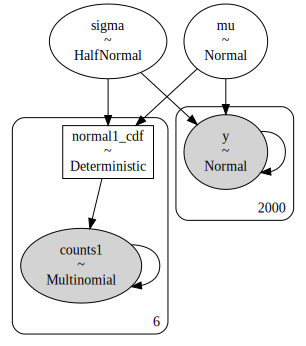

In [38]:
pm.model_to_graphviz(model4)

In [39]:
with model4:
    trace4 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


### Posterior predictive checks

In [40]:
with model4:
    ppc = pm.sample_posterior_predictive(trace4)

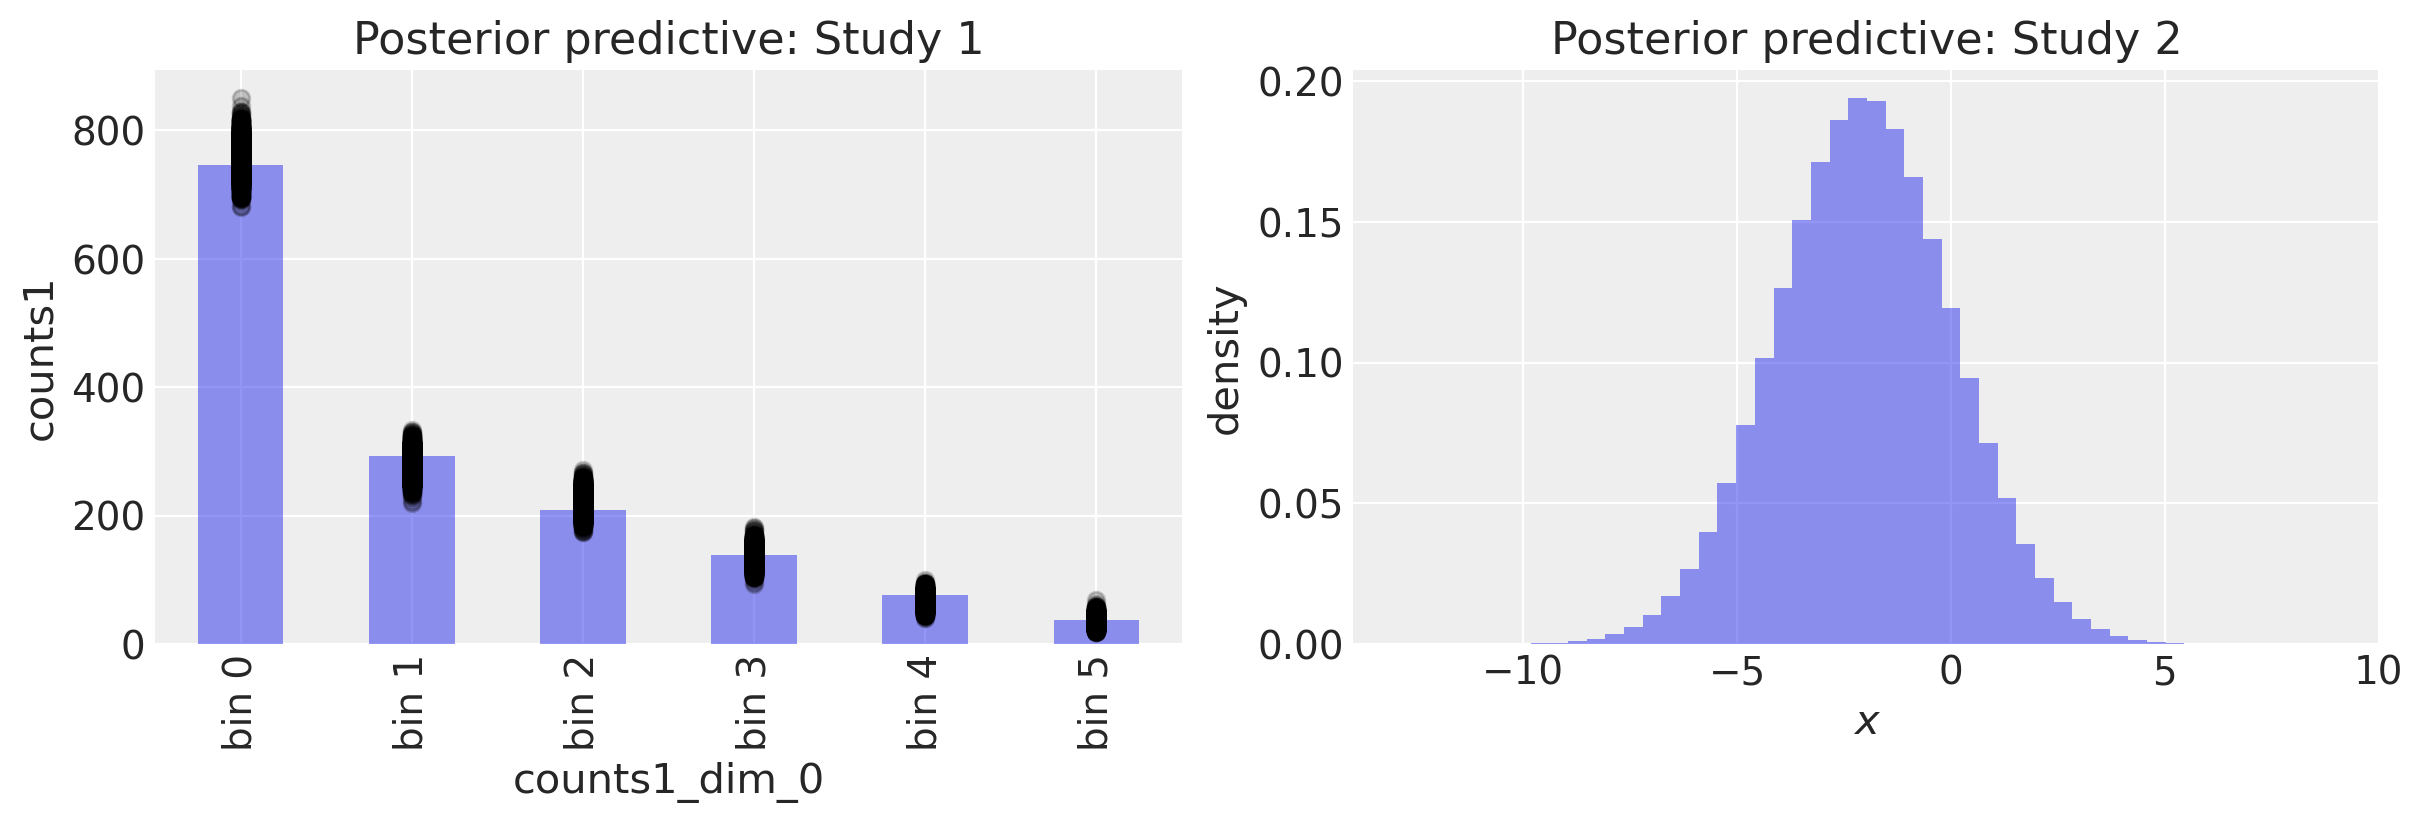

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Study 1 ----------------------------------------------------------------
# Plot observed bin counts
c1.plot(kind="bar", ax=ax[0], alpha=0.5)
# Plot posterior predictive
ppc.posterior_predictive.plot.scatter(
    x="counts1_dim_0", y="counts1", color="k", alpha=0.2, ax=ax[0]
)
# Formatting
ax[0].set_xticklabels([f"bin {n}" for n in range(len(c1))])
ax[0].set_title("Posterior predictive: Study 1")

# Study 2 ----------------------------------------------------------------
ax[1].hist(ppc.posterior_predictive.y.values.flatten(), 50, density=True, alpha=0.5)
ax[1].set(title="Posterior predictive: Study 2", xlabel="$x$", ylabel="density");

We can calculate the mean and standard deviation of the posterior predictive distribution for study 2 and see that they are close to our true parameters.

In [42]:
np.mean(ppc.posterior_predictive.y.values.flatten()), np.std(
    ppc.posterior_predictive.y.values.flatten()
)

(-2.030965696788321, 2.0470152029638515)

### Recovering parameters
Finally, we can check the posterior estimates of the parameters and see that the estimates here are spot on.

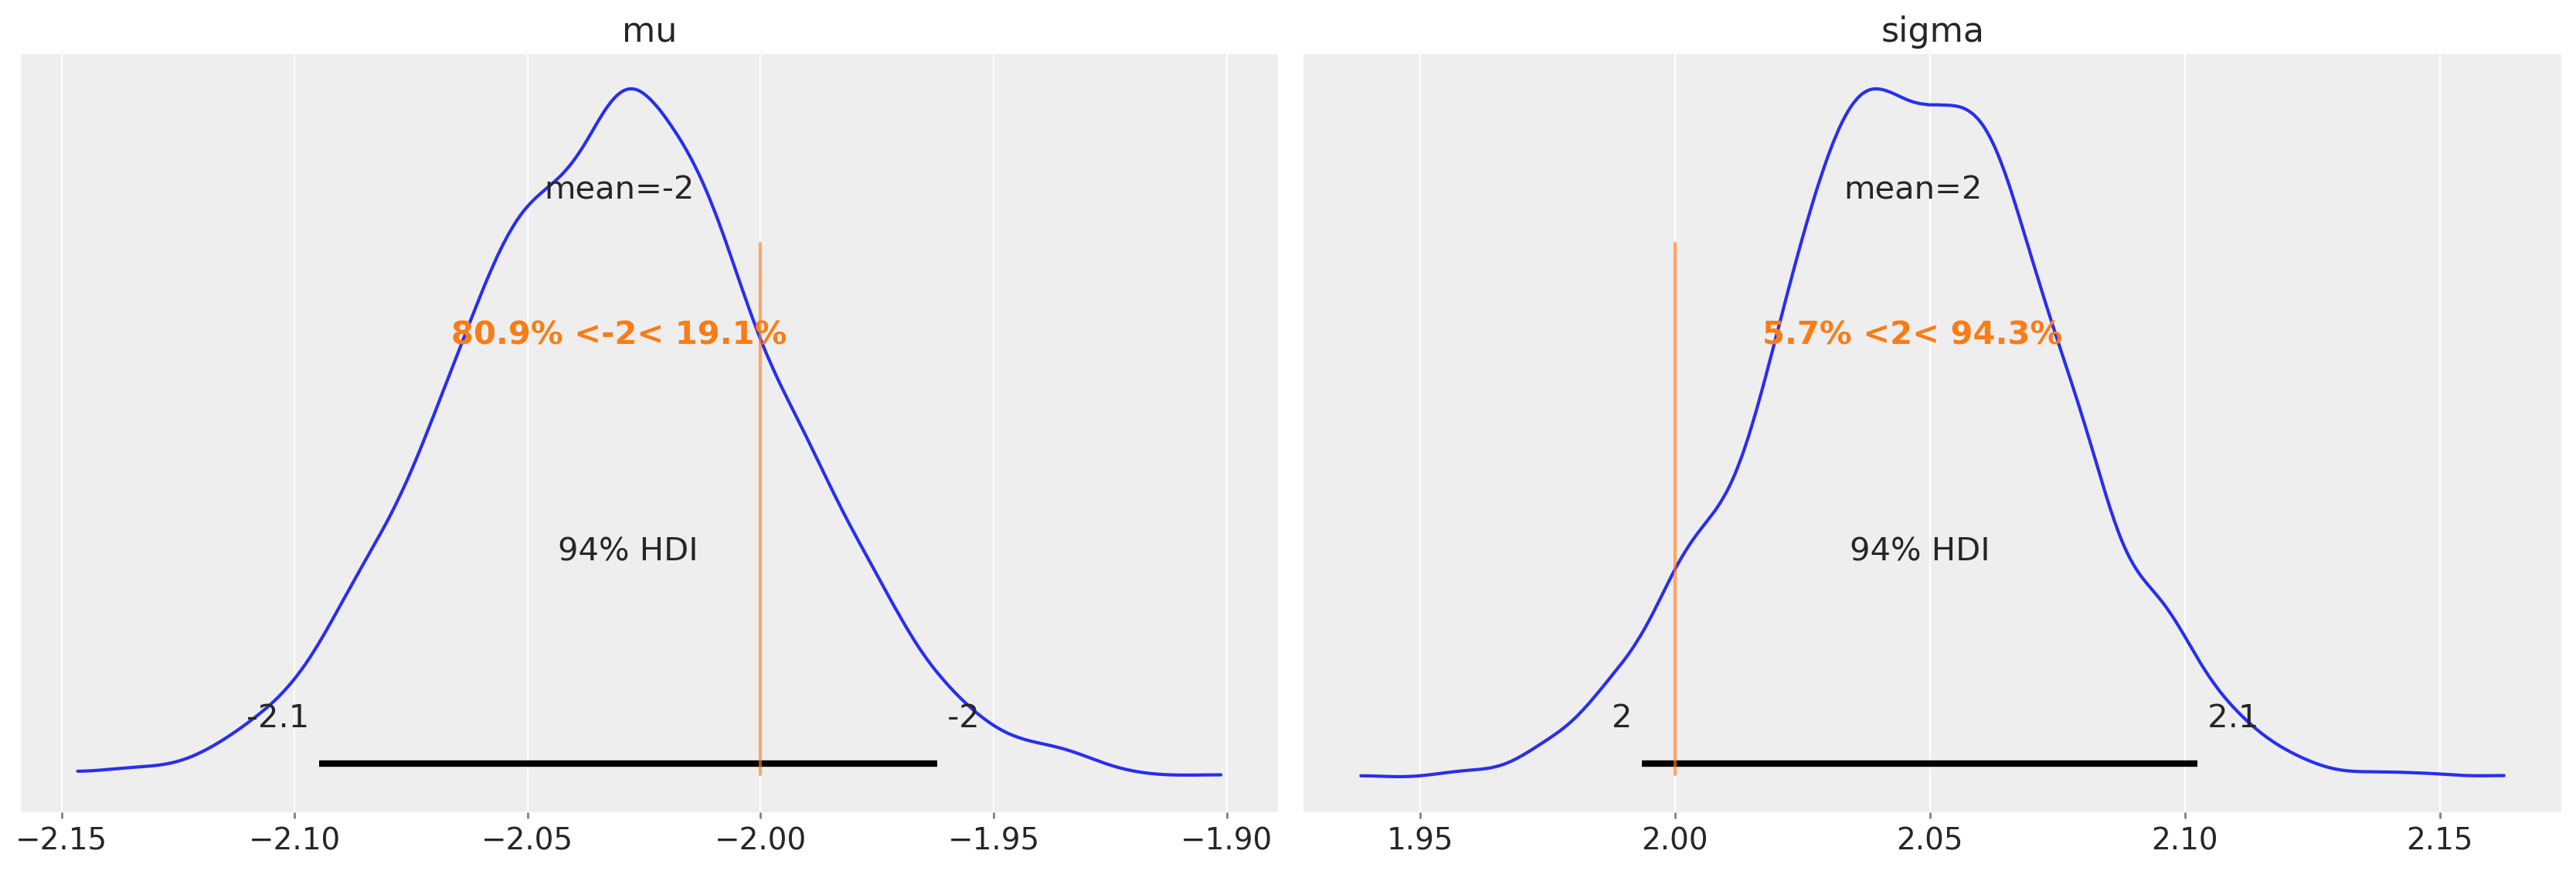

In [43]:
az.plot_posterior(trace4, var_names=["mu", "sigma"], ref_val=[true_mu, true_sigma]);

## Example 5: Hierarchical estimation
The previous examples all assumed that study 1 and study 2 data were sampled from the same population. While this was in fact true for our simulated data, when we are working with real data, we are not in a position to know this. So it could be useful to be able to ask the question, "does it look like data from study 1 and study 2 are drawn from the same population?"

We can do this using the same basic approach - we can estimate population level parameters like before, but now we can add in _study level_ parameter estimates. This will be a new hierarchical layer in our model between the population level parameters and the observations.

### Model specification

This time, because we are getting into a more complicated model, we will use `coords` to tell PyMC about the dimensionality of the variables. This feeds in to the posterior samples which are outputted in xarray format, which makes life easier when processing posterior samples for statistical or visualization purposes later.

In [44]:
coords = {
    "study": np.array([0, 1]),
    "bin1": np.arange(len(c1)),
    "bin2": np.arange(len(c2)),
}

In [45]:
with pm.Model(coords=coords) as model5:
    # Population level priors
    mu_pop_mean = pm.Normal("mu_pop_mean", 0.0, 1.0)
    mu_pop_variance = pm.HalfNormal("mu_pop_variance", sigma=1)

    sigma_pop_mean = pm.HalfNormal("sigma_pop_mean", sigma=1)
    sigma_pop_sigma = pm.HalfNormal("sigma_pop_sigma", sigma=1)

    # Study level priors
    mu = pm.Normal("mu", mu=mu_pop_mean, sigma=mu_pop_variance, dims="study")
    sigma = pm.TruncatedNormal(
        "sigma", mu=sigma_pop_mean, sigma=sigma_pop_sigma, lower=0, dims="study"
    )

    # Study 1
    probs1 = pm.math.exp(pm.logcdf(pm.Normal.dist(mu=mu[0], sigma=sigma[0]), d1))
    probs1 = at.extra_ops.diff(pm.math.concatenate([np.array([0]), probs1, np.array([1])]))
    probs1 = pm.Deterministic("normal1_cdf", probs1, dims="bin1")

    # Study 2
    probs2 = pm.math.exp(pm.logcdf(pm.Normal.dist(mu=mu[1], sigma=sigma[1]), d2))
    probs2 = at.extra_ops.diff(pm.math.concatenate([np.array([0]), probs2, np.array([1])]))
    probs2 = pm.Deterministic("normal2_cdf", probs2, dims="bin2")

    # Likelihood
    pm.Multinomial("counts1", p=probs1, n=c1.sum(), observed=c1.values, dims="bin1")
    pm.Multinomial("counts2", p=probs2, n=c2.sum(), observed=c2.values, dims="bin2")

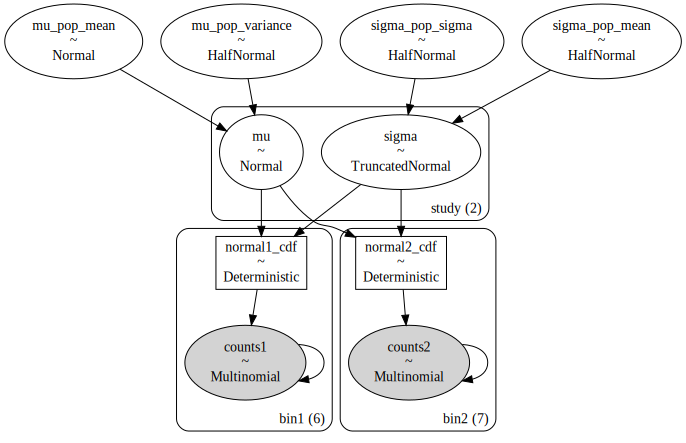

In [46]:
pm.model_to_graphviz(model5)

The model above is fine _but_ running this model as it is results in hundreds of divergences in the sampling process (you can find out more about divergences from the {ref}`diagnosing_with_divergences` notebook). While we won't go deep into the reasons here, the long story cut short is that Gaussian centering introduces pathologies into our log likelihood space that make it difficult for MCMC samplers to work. Firstly, we removed the population level estimates on `sigma` and just stick with study level priors. We used the Gamma distribution to avoid any zero values. Secondly use a non-centered reparameterization to specify `mu`. This does not completely solve the problem, but it does drastically reduce the number of divergences.

In [47]:
with pm.Model(coords=coords) as model5:
    # Population level priors
    mu_pop_mean = pm.Normal("mu_pop_mean", 0.0, 1.0)
    mu_pop_variance = pm.HalfNormal("mu_pop_variance", sigma=1)

    # Study level priors
    x = pm.Normal("x", dims="study")
    mu = pm.Deterministic("mu", x * mu_pop_variance + mu_pop_mean, dims="study")

    sigma = pm.Gamma("sigma", alpha=2, beta=1, dims="study")

    # Study 1
    probs1 = pm.math.exp(pm.logcdf(pm.Normal.dist(mu=mu[0], sigma=sigma[0]), d1))
    probs1 = at.extra_ops.diff(pm.math.concatenate([np.array([0]), probs1, np.array([1])]))
    probs1 = pm.Deterministic("normal1_cdf", probs1, dims="bin1")

    # Study 2
    probs2 = pm.math.exp(pm.logcdf(pm.Normal.dist(mu=mu[1], sigma=sigma[1]), d2))
    probs2 = at.extra_ops.diff(pm.math.concatenate([np.array([0]), probs2, np.array([1])]))
    probs2 = pm.Deterministic("normal2_cdf", probs2, dims="bin2")

    # Likelihood
    pm.Multinomial("counts1", p=probs1, n=c1.sum(), observed=c1.values, dims="bin1")
    pm.Multinomial("counts2", p=probs2, n=c2.sum(), observed=c2.values, dims="bin2")

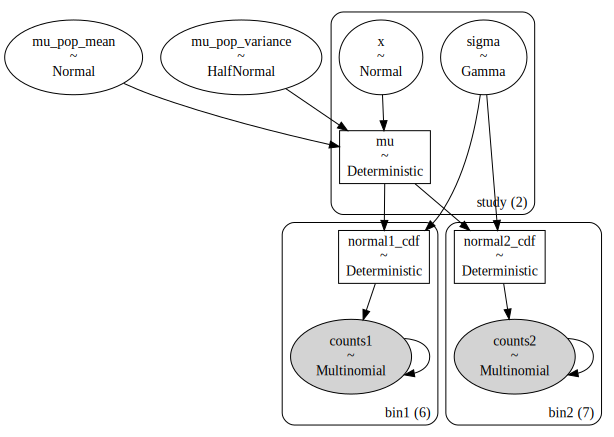

In [48]:
pm.model_to_graphviz(model5)

In [49]:
with model5:
    trace5 = pm.sample(tune=2000, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop_mean, mu_pop_variance, x, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 161 seconds.


We can see that despite our efforts, we still get some divergences. Plotting the samples and highlighting the divergences suggests (from the top left subplot) that our model is suffering from the funnel problem

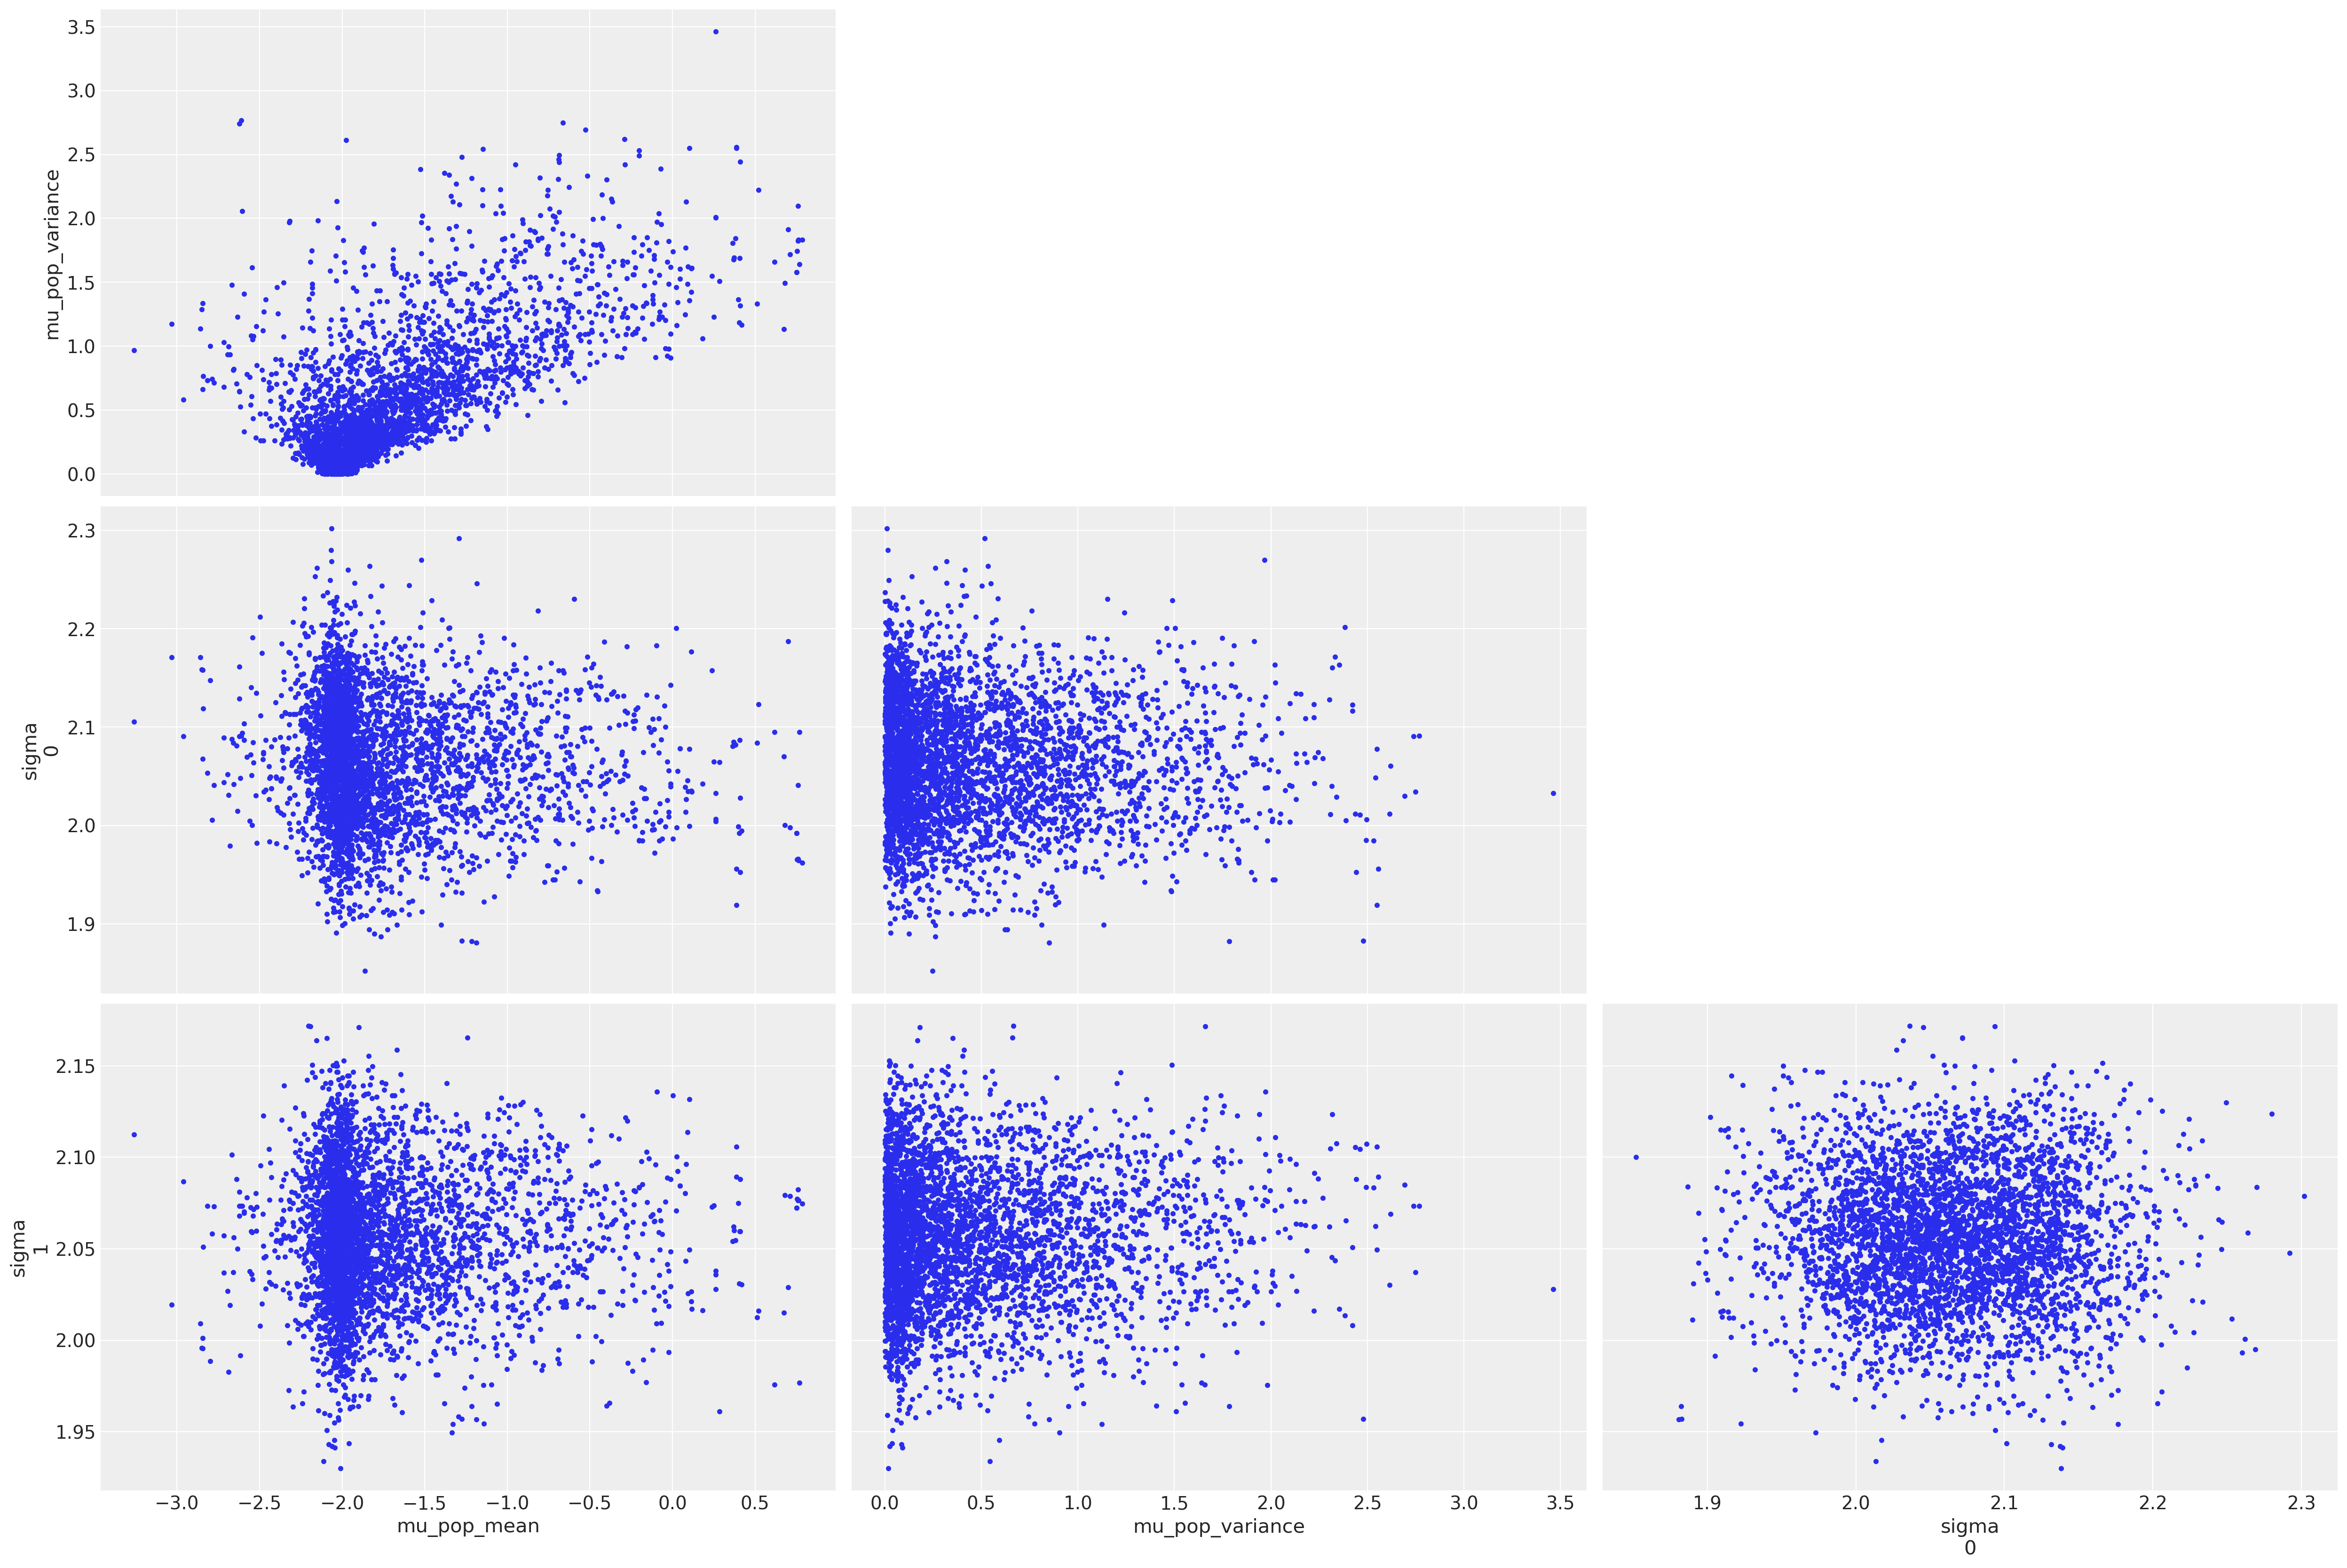

In [50]:
az.plot_pair(
    trace5, var_names=["mu_pop_mean", "mu_pop_variance", "sigma"], coords=coords, divergences=True
);

### Posterior predictive checks

In [51]:
with model5:
    ppc = pm.sample_posterior_predictive(trace5)

Text(0.5, 1.0, 'Seven bin discretization of N(-2, 2)')

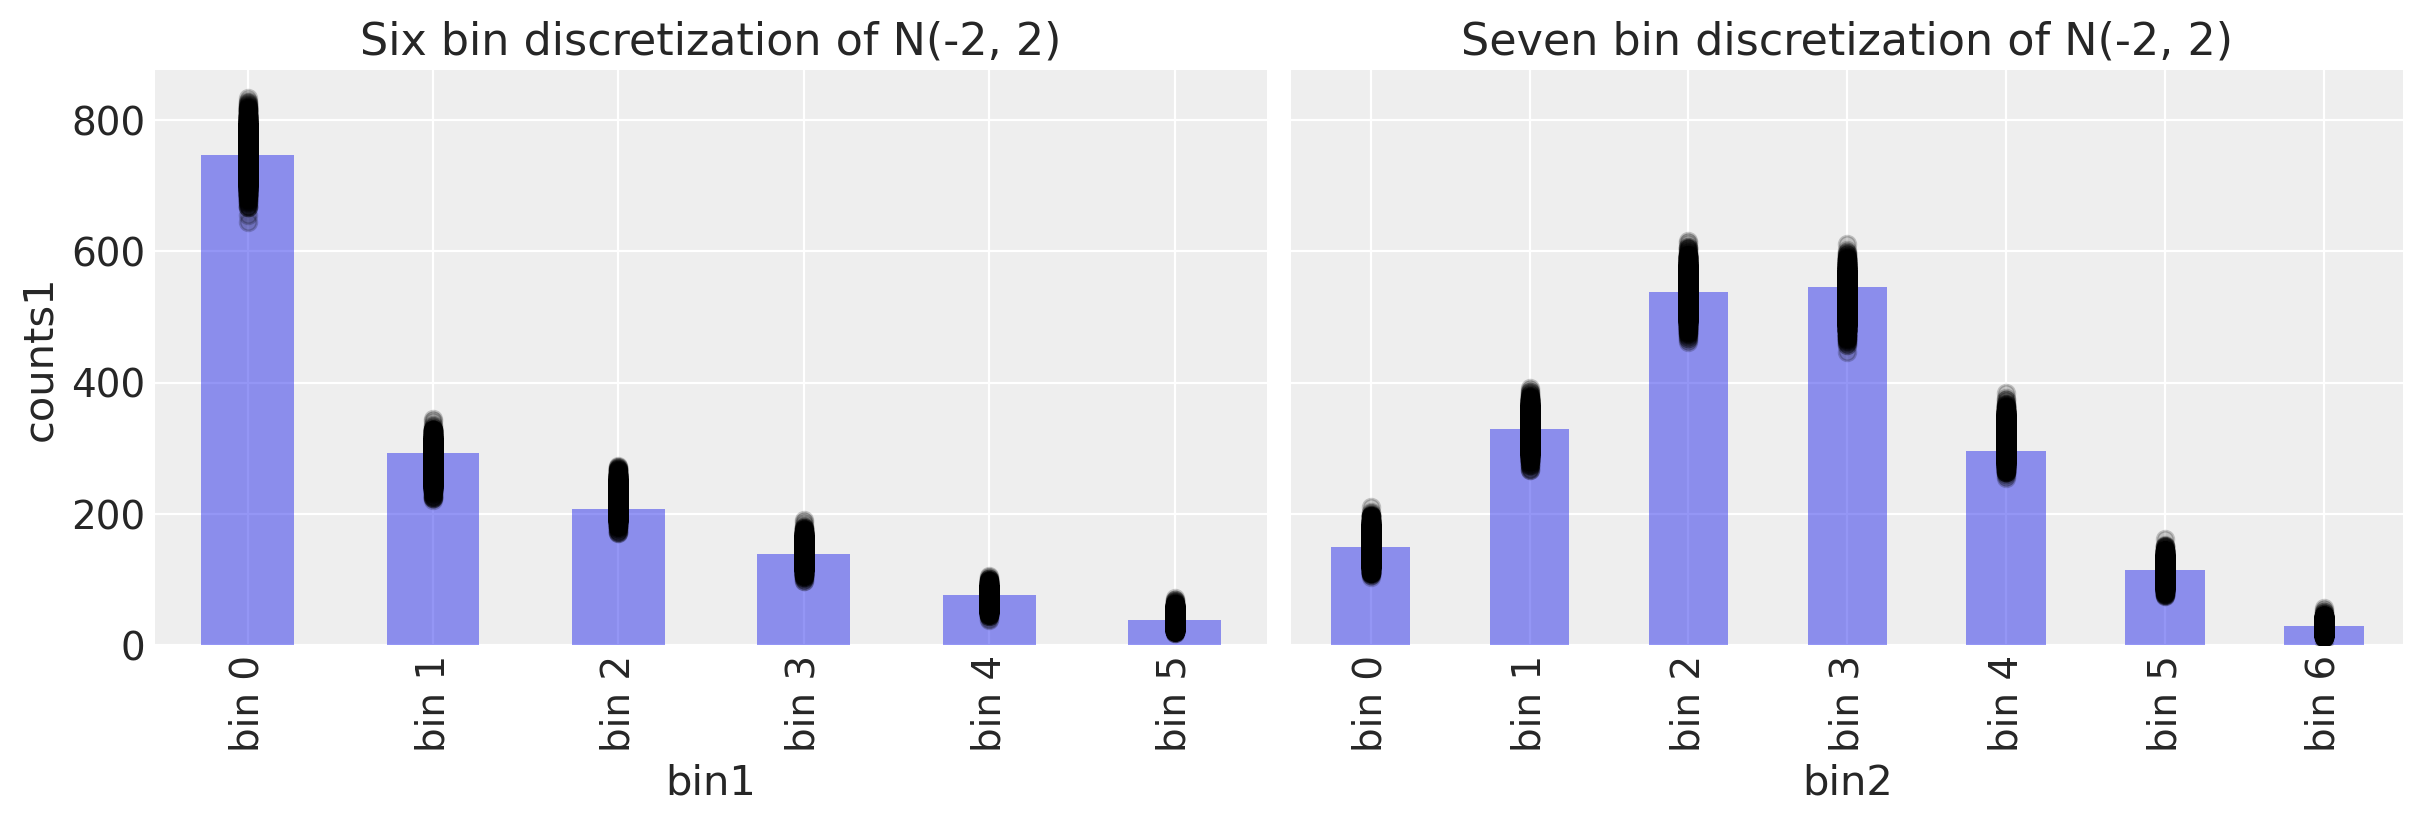

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Study 1 ----------------------------------------------------------------
# Plot observed bin counts
c1.plot(kind="bar", ax=ax[0], alpha=0.5)
# Plot posterior predictive
ppc.posterior_predictive.plot.scatter(x="bin1", y="counts1", color="k", alpha=0.2, ax=ax[0])
# Formatting
ax[0].set_xticklabels([f"bin {n}" for n in range(len(c1))])
ax[0].set_title("Six bin discretization of N(-2, 2)")

# Study 1 ----------------------------------------------------------------
# Plot observed bin counts
c2.plot(kind="bar", ax=ax[1], alpha=0.5)
# Plot posterior predictive
ppc.posterior_predictive.plot.scatter(x="bin2", y="counts2", color="k", alpha=0.2, ax=ax[1])
# Formatting
ax[1].set_xticklabels([f"bin {n}" for n in range(len(c2))])
ax[1].set_title("Seven bin discretization of N(-2, 2)")

### Inspect posterior

Any evidence for differences in study-level means or standard deviations?

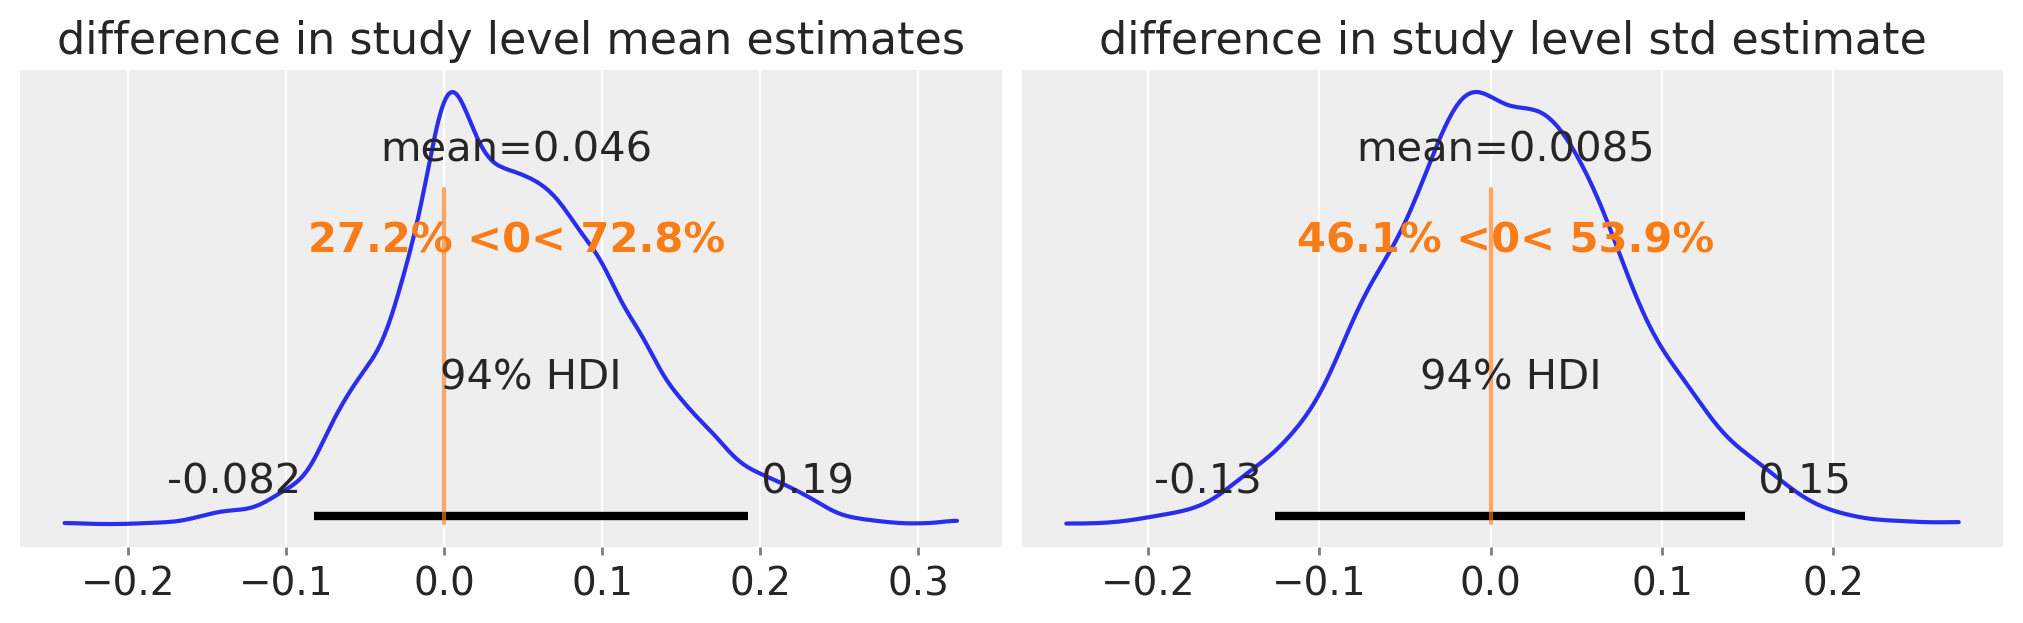

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

diff = trace5.posterior.mu.sel(study=0) - trace5.posterior.mu.sel(study=1)
az.plot_posterior(diff, ref_val=0, ax=ax[0])
ax[0].set(title="difference in study level mean estimates")

diff = trace5.posterior.sigma.sel(study=0) - trace5.posterior.sigma.sel(study=1)
az.plot_posterior(diff, ref_val=0, ax=ax[1])
ax[1].set(title="difference in study level std estimate");

No compelling evidence for differences between the population level means and standard deviations.

Population level estimates in the mean parameter. There is no population level estimate of sigma in this reparameterised model.

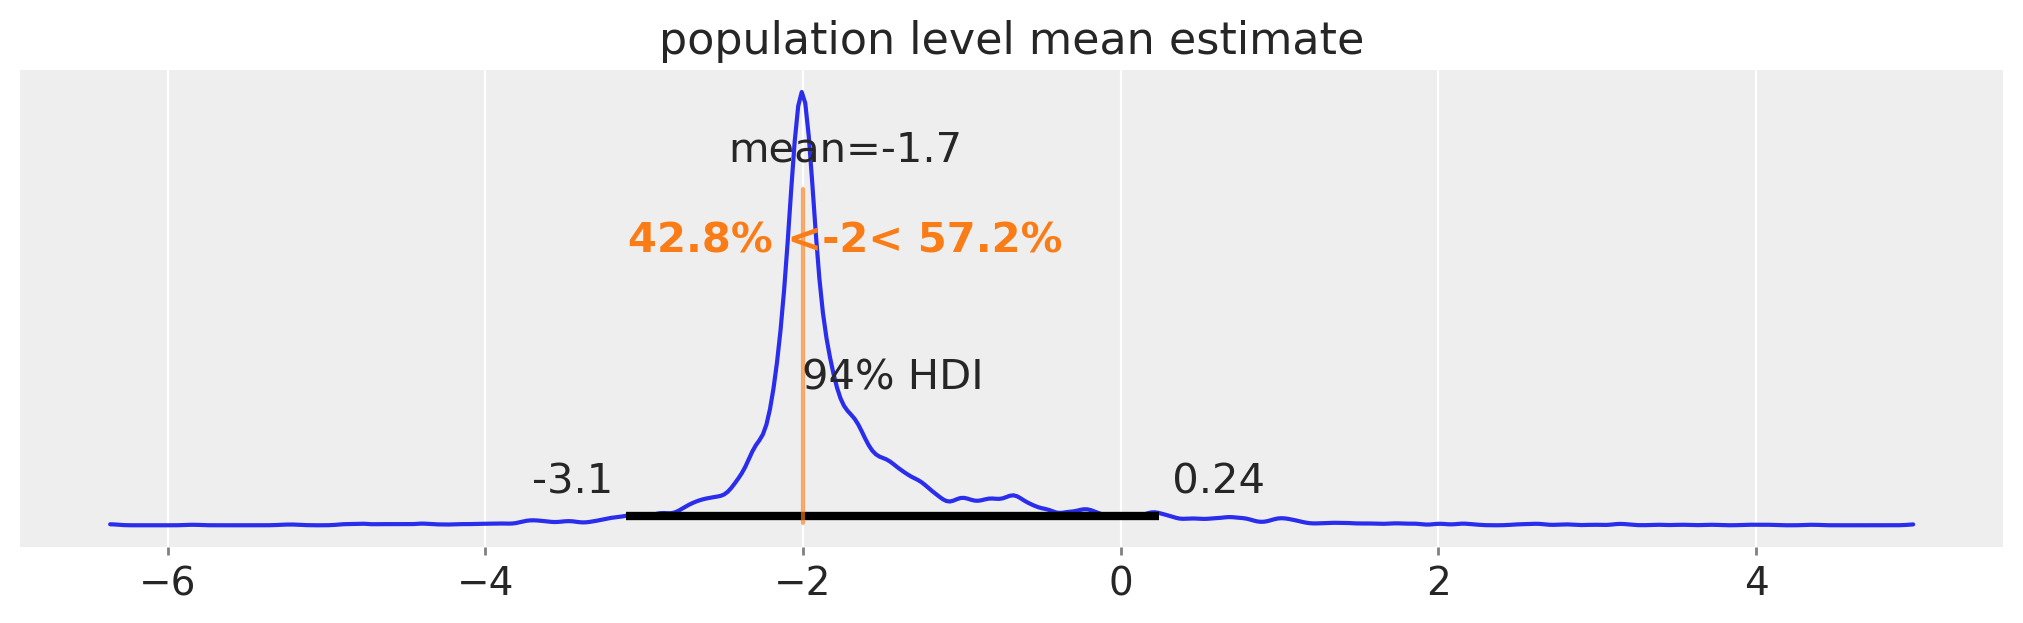

In [54]:
fig, ax = plt.subplots(figsize=(10, 3))

pop_mean = rng.normal(
    trace5.posterior.mu_pop_mean.values.flatten(), trace5.posterior.mu_pop_variance.values.flatten()
)
az.plot_posterior(pop_mean, ax=ax, ref_val=true_mu)
ax.set(title="population level mean estimate");

Another possible solution would be to make independent inferences about the study level parameters from group 1 and group 2, and then look for any evidendence that these differ. Taking this approach works just fine, no divergences in sight, although this approach drifts away from our core goal of making population level inferences. Rather than fully work through this example, we included the code in case it is useful to anyone's use case.

```python
with pm.Model(coords=coords) as model5:
    # Study level priors
    mu = pm.Normal("mu", dims='study')
    sigma = pm.HalfNormal("sigma", dims='study')
    
    # Study 1
    probs1 = pm.math.exp(pm.logcdf(pm.Normal.dist(mu=mu[0], sigma=sigma[0]), d1))
    probs1 = at.extra_ops.diff(pm.math.concatenate([np.array([0]), probs1, np.array([1])]))
    probs1 = pm.Deterministic("normal1_cdf", probs1, dims='bin1')

    # Study 2
    probs2 = pm.math.exp(pm.logcdf(pm.Normal.dist(mu=mu[1], sigma=sigma[1]), d2))
    probs2 = at.extra_ops.diff(pm.math.concatenate([np.array([0]), probs2, np.array([1])]))
    probs2 = pm.Deterministic("normal2_cdf", probs2, dims='bin2')

    # Likelihood
    pm.Multinomial("counts1", p=probs1, n=c1.sum(), observed=c1.values, dims='bin1')
    pm.Multinomial("counts2", p=probs2, n=c2.sum(), observed=c2.values, dims='bin2')
```

## Example 6: A non-normal distribution

In theory, the method we're using is quite general. Its dependencies are usually well-specified:

- A parametric distribution
- Known cut points on the support of that distribution to bin our data
- Counts (and hence proportions) of each bin

We will now empirically verify that the parameters of other distributions are recoverable using the same methods. We will approximate the distribution of [Body Mass Index](https://en.wikipedia.org/wiki/Body_mass_index) (BMI) from 2 hypothetical (simulated) studies. 

In the first study, the fictional researchers used a set of thresholds which give them many categories of:
- Underweight (Severe thinness): $< 16$
- Underweight (Moderate thinness): $16 - 17$
- Underweight (Mild thinness): $17 - 18.5$
- Normal range: $18.5 - 25$
- Overweight (Pre-obese): $25 - 30$
- Obese (Class I): $30 - 35$
- Obese (Class II): $35 - 40$
- Obese (Class III): $\ge 40$

The second set of researchers used a categorisation scheme recommended by the Hospital Authority of Hong Kong:
- Underweight (Unhealthy): $< 18.5$
- Normal range (Healthy): $18.5 - 23$
- Overweight I (At risk): $23 - 25$
- Overweight II (Moderately obese): $25 - 30$
- Overweight III (Severely obese): $\ge 30$

In [55]:
# First discretization
d1 = np.array([16, 17, 18.5, 25, 30, 35, 40])
# Second discretization
d2 = np.array([18.5, 23, 30])

We assume the true underlying BMI distribution is Gumbel distributed with mu and beta parameters of 20 and 4, respectively.

In [56]:
# True underlying BMI distribution
true_mu, true_beta = 20, 4
BMI = pm.Gumbel.dist(mu=true_mu, beta=true_beta)

# Generate two different sets of random samples from the same Gaussian.
x1 = pm.draw(BMI, 800)
x2 = pm.draw(BMI, 1200)

# Calculate bin counts
c1 = data_to_bincounts(x1, d1)
c2 = data_to_bincounts(x2, d2)

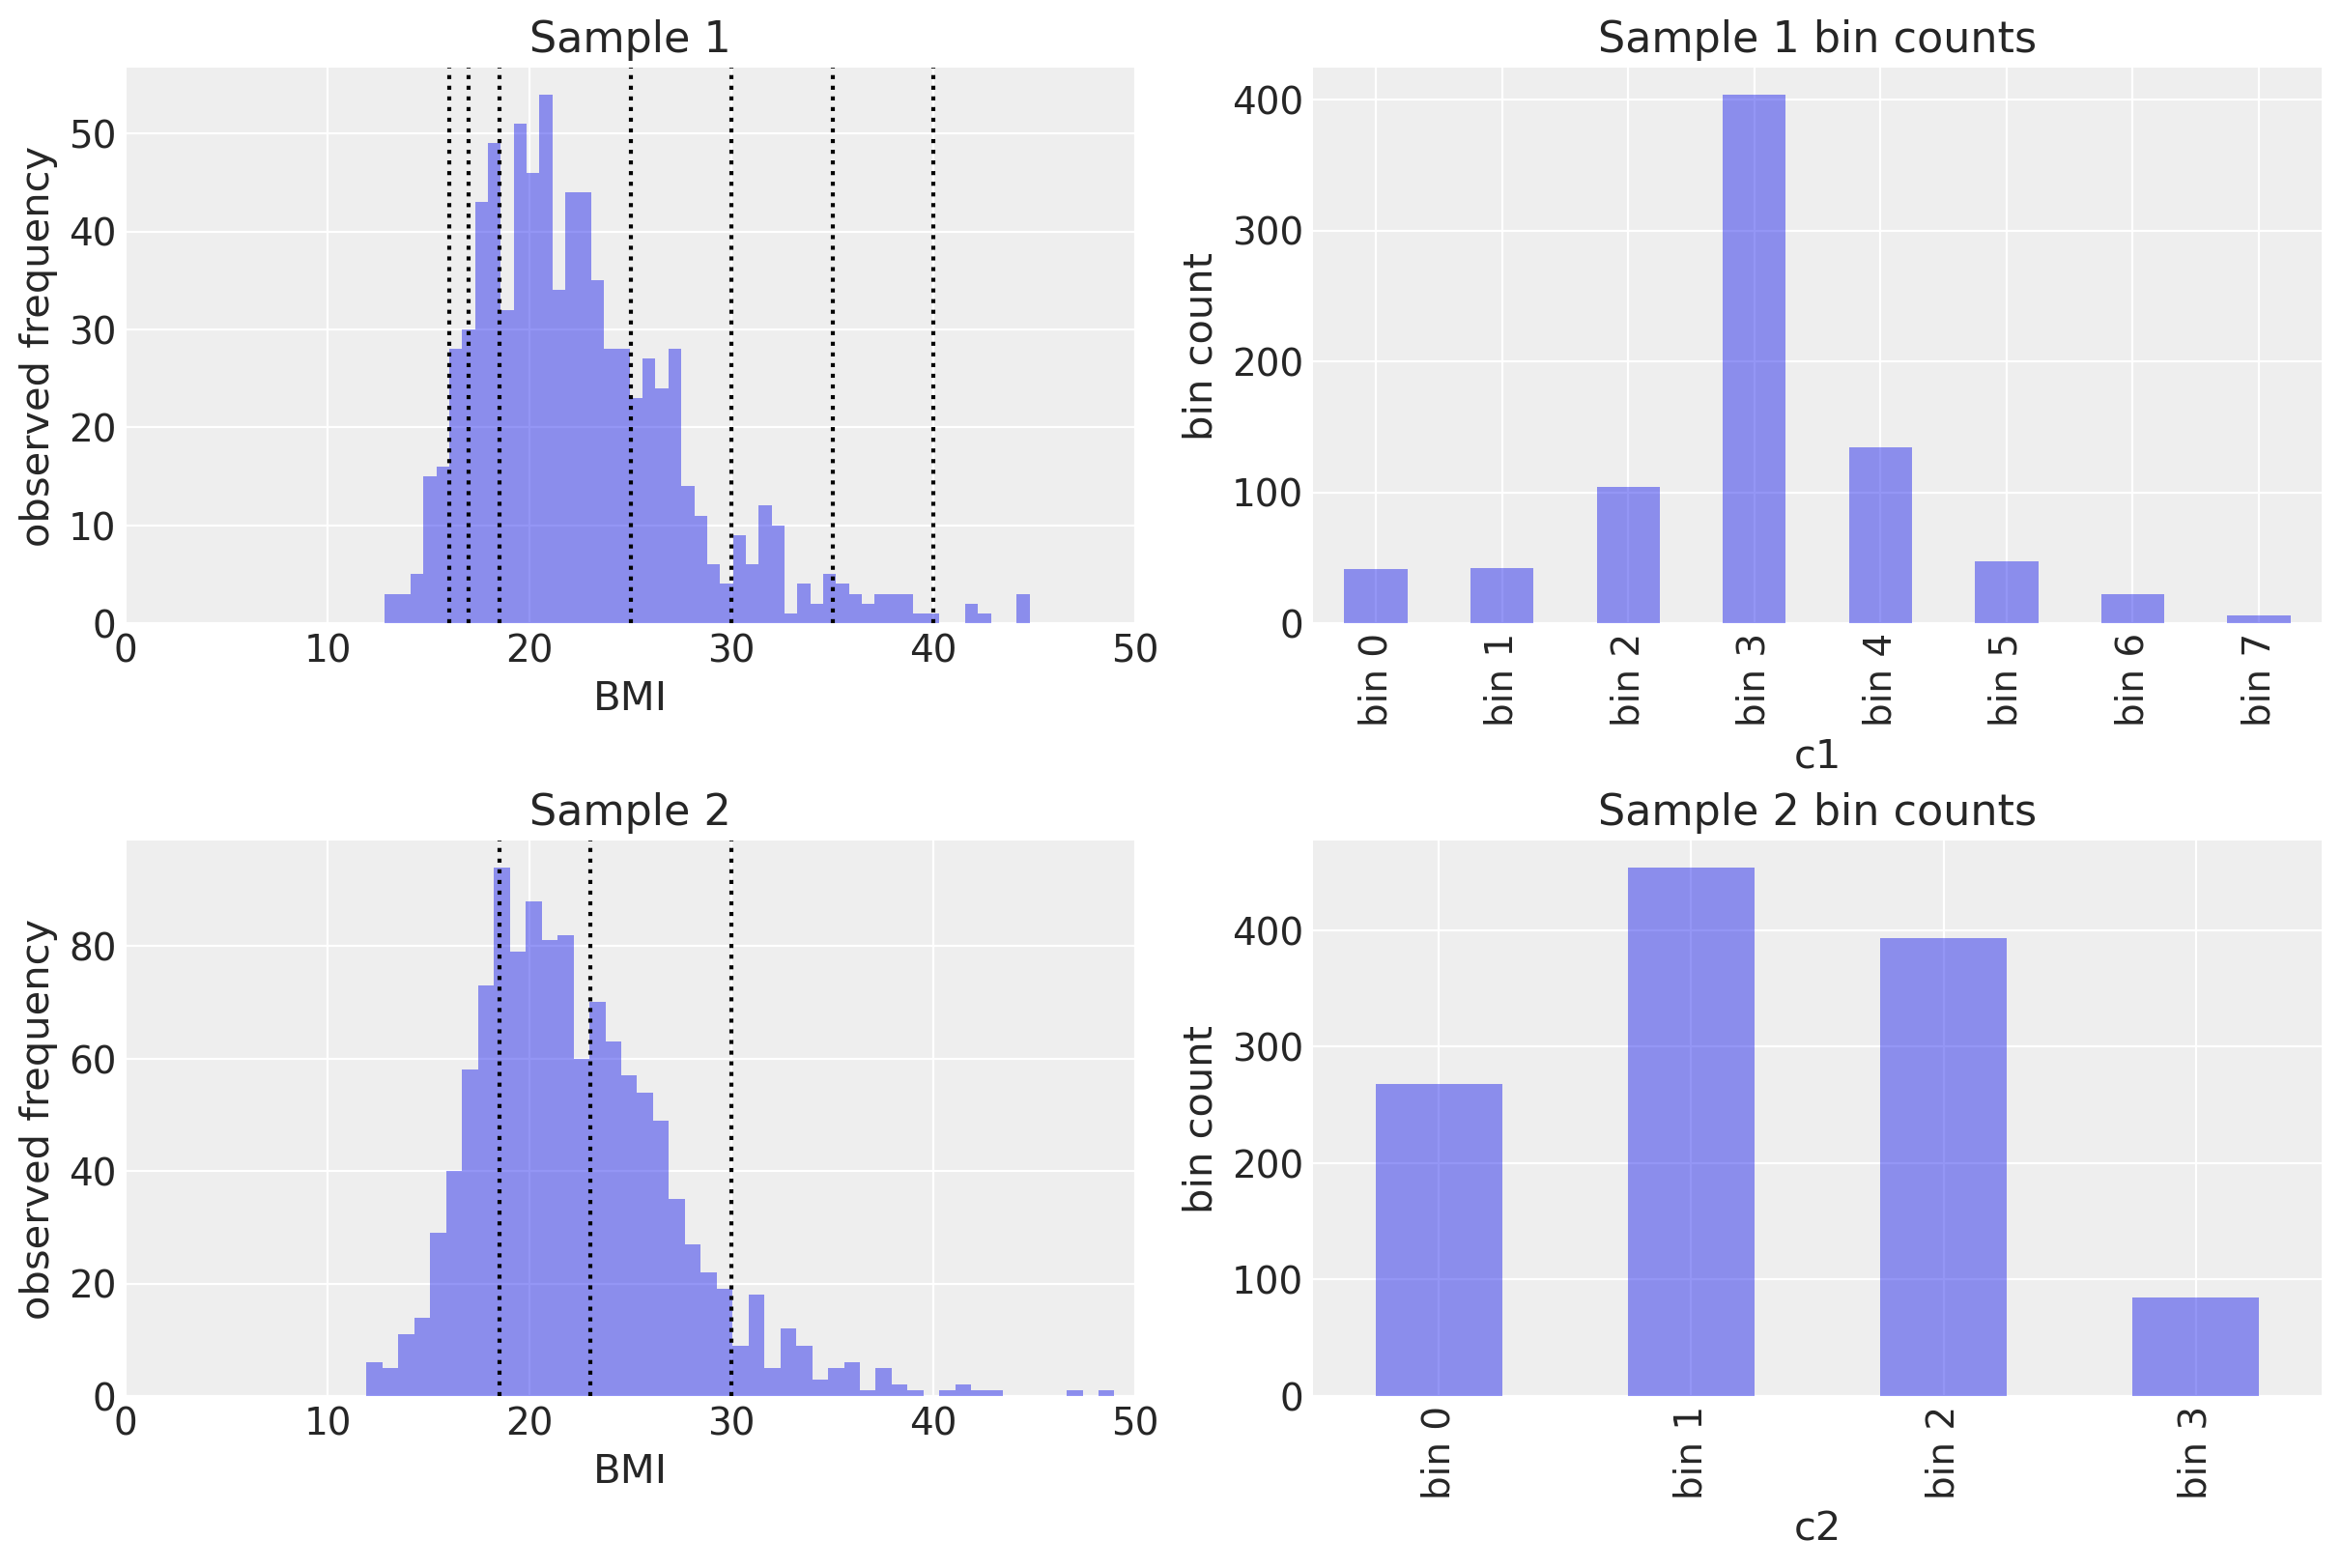

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# First set of measurements ----------------------------------------------
ax[0, 0].hist(x1, 50, alpha=0.5)

for cut in d1:
    ax[0, 0].axvline(cut, color="k", ls=":")

# Plot observed bin counts
c1.plot(kind="bar", ax=ax[0, 1], alpha=0.5)
ax[0, 1].set_xticklabels([f"bin {n}" for n in range(len(c1))])
ax[0, 1].set(title="Sample 1 bin counts", xlabel="c1", ylabel="bin count")

# Second set of measuremsnts ---------------------------------------------
ax[1, 0].hist(x2, 50, alpha=0.5)

for cut in d2:
    ax[1, 0].axvline(cut, color="k", ls=":")

# Plot observed bin counts
c2.plot(kind="bar", ax=ax[1, 1], alpha=0.5)
ax[1, 1].set_xticklabels([f"bin {n}" for n in range(len(c2))])
ax[1, 1].set(title="Sample 2 bin counts", xlabel="c2", ylabel="bin count")

# format axes ------------------------------------------------------------
ax[0, 0].set(xlim=(0, 50), xlabel="BMI", ylabel="observed frequency", title="Sample 1")
ax[1, 0].set(xlim=(0, 50), xlabel="BMI", ylabel="observed frequency", title="Sample 2");

### Model specification

This is a variation of Example 3 above. The only changes are:
- update the probability distribution to match our target (the Gumbel distribution)
- ensure we specify priors for our target distribution, appropriate given our domain knowledge.

In [58]:
with pm.Model() as model6:
    mu = pm.Normal("mu", 20, 5)
    beta = pm.HalfNormal("beta", 10)

    probs1 = pm.math.exp(pm.logcdf(pm.Gumbel.dist(mu=mu, beta=beta), d1))
    probs1 = at.extra_ops.diff(pm.math.concatenate([np.array([0]), probs1, np.array([1])]))
    probs1 = pm.Deterministic("gumbel_cdf1", probs1)

    probs2 = pm.math.exp(pm.logcdf(pm.Gumbel.dist(mu=mu, beta=beta), d2))
    probs2 = at.extra_ops.diff(pm.math.concatenate([np.array([0]), probs2, np.array([1])]))
    probs2 = pm.Deterministic("gumbel_cdf2", probs2)

    pm.Multinomial("counts1", p=probs1, n=c1.sum(), observed=c1.values)
    pm.Multinomial("counts2", p=probs2, n=c2.sum(), observed=c2.values)

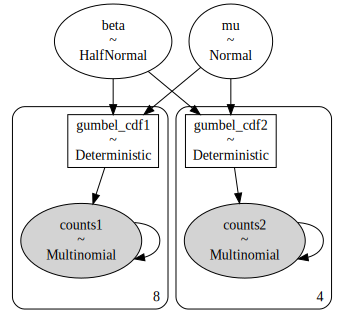

In [59]:
pm.model_to_graphviz(model6)

In [60]:
with model6:
    trace6 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8809, but should be close to 0.8. Try to increase the number of tuning steps.


### Posterior predictive checks

In [61]:
with model6:
    ppc = pm.sample_posterior_predictive(trace6)

Text(0.5, 1.0, 'Study 2')

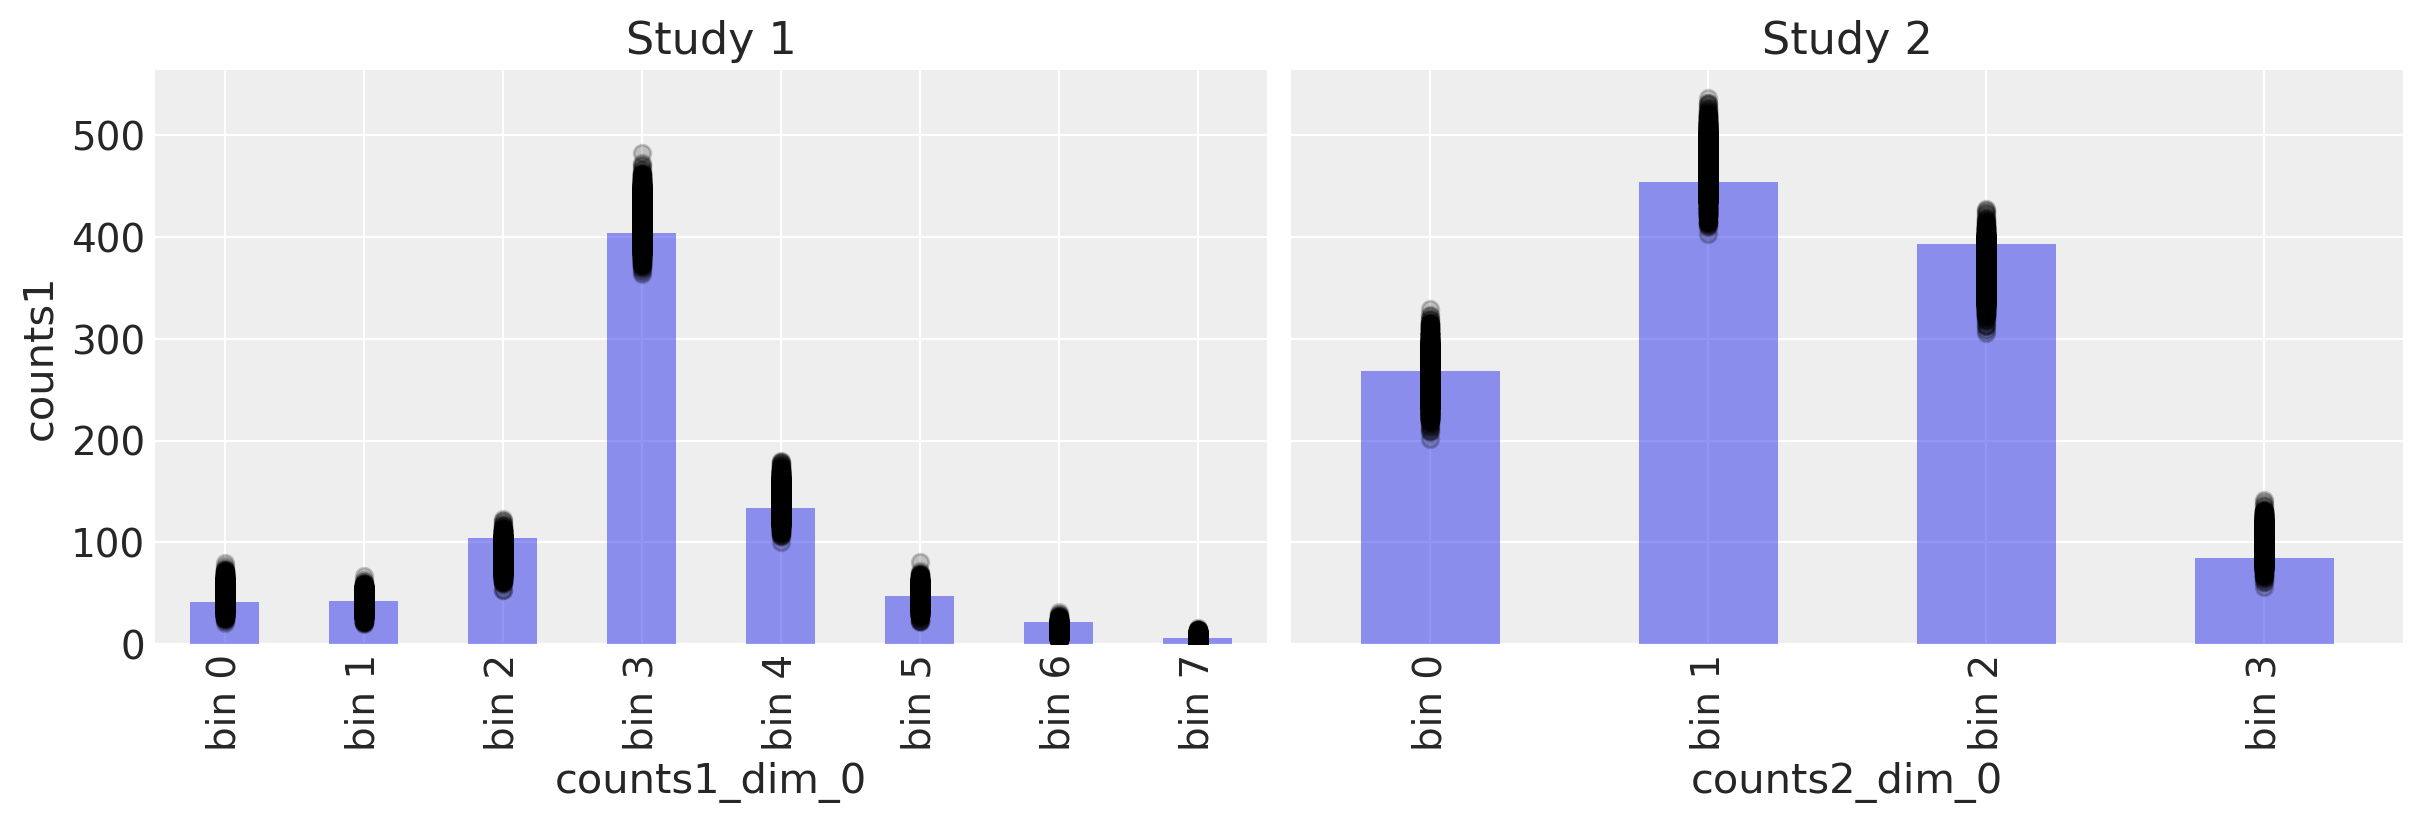

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Study 1 ----------------------------------------------------------------
# Plot observed bin counts
c1.plot(kind="bar", ax=ax[0], alpha=0.5)
# Plot posterior predictive
ppc.posterior_predictive.plot.scatter(
    x="counts1_dim_0", y="counts1", color="k", alpha=0.2, ax=ax[0]
)
# Formatting
ax[0].set_xticklabels([f"bin {n}" for n in range(len(c1))])
ax[0].set_title("Study 1")

# Study 1 ----------------------------------------------------------------
# Plot observed bin counts
c2.plot(kind="bar", ax=ax[1], alpha=0.5)
# Plot posterior predictive
ppc.posterior_predictive.plot.scatter(
    x="counts2_dim_0", y="counts2", color="k", alpha=0.2, ax=ax[1]
)
# Formatting
ax[1].set_xticklabels([f"bin {n}" for n in range(len(c2))])
ax[1].set_title("Study 2")

### Recovering parameters

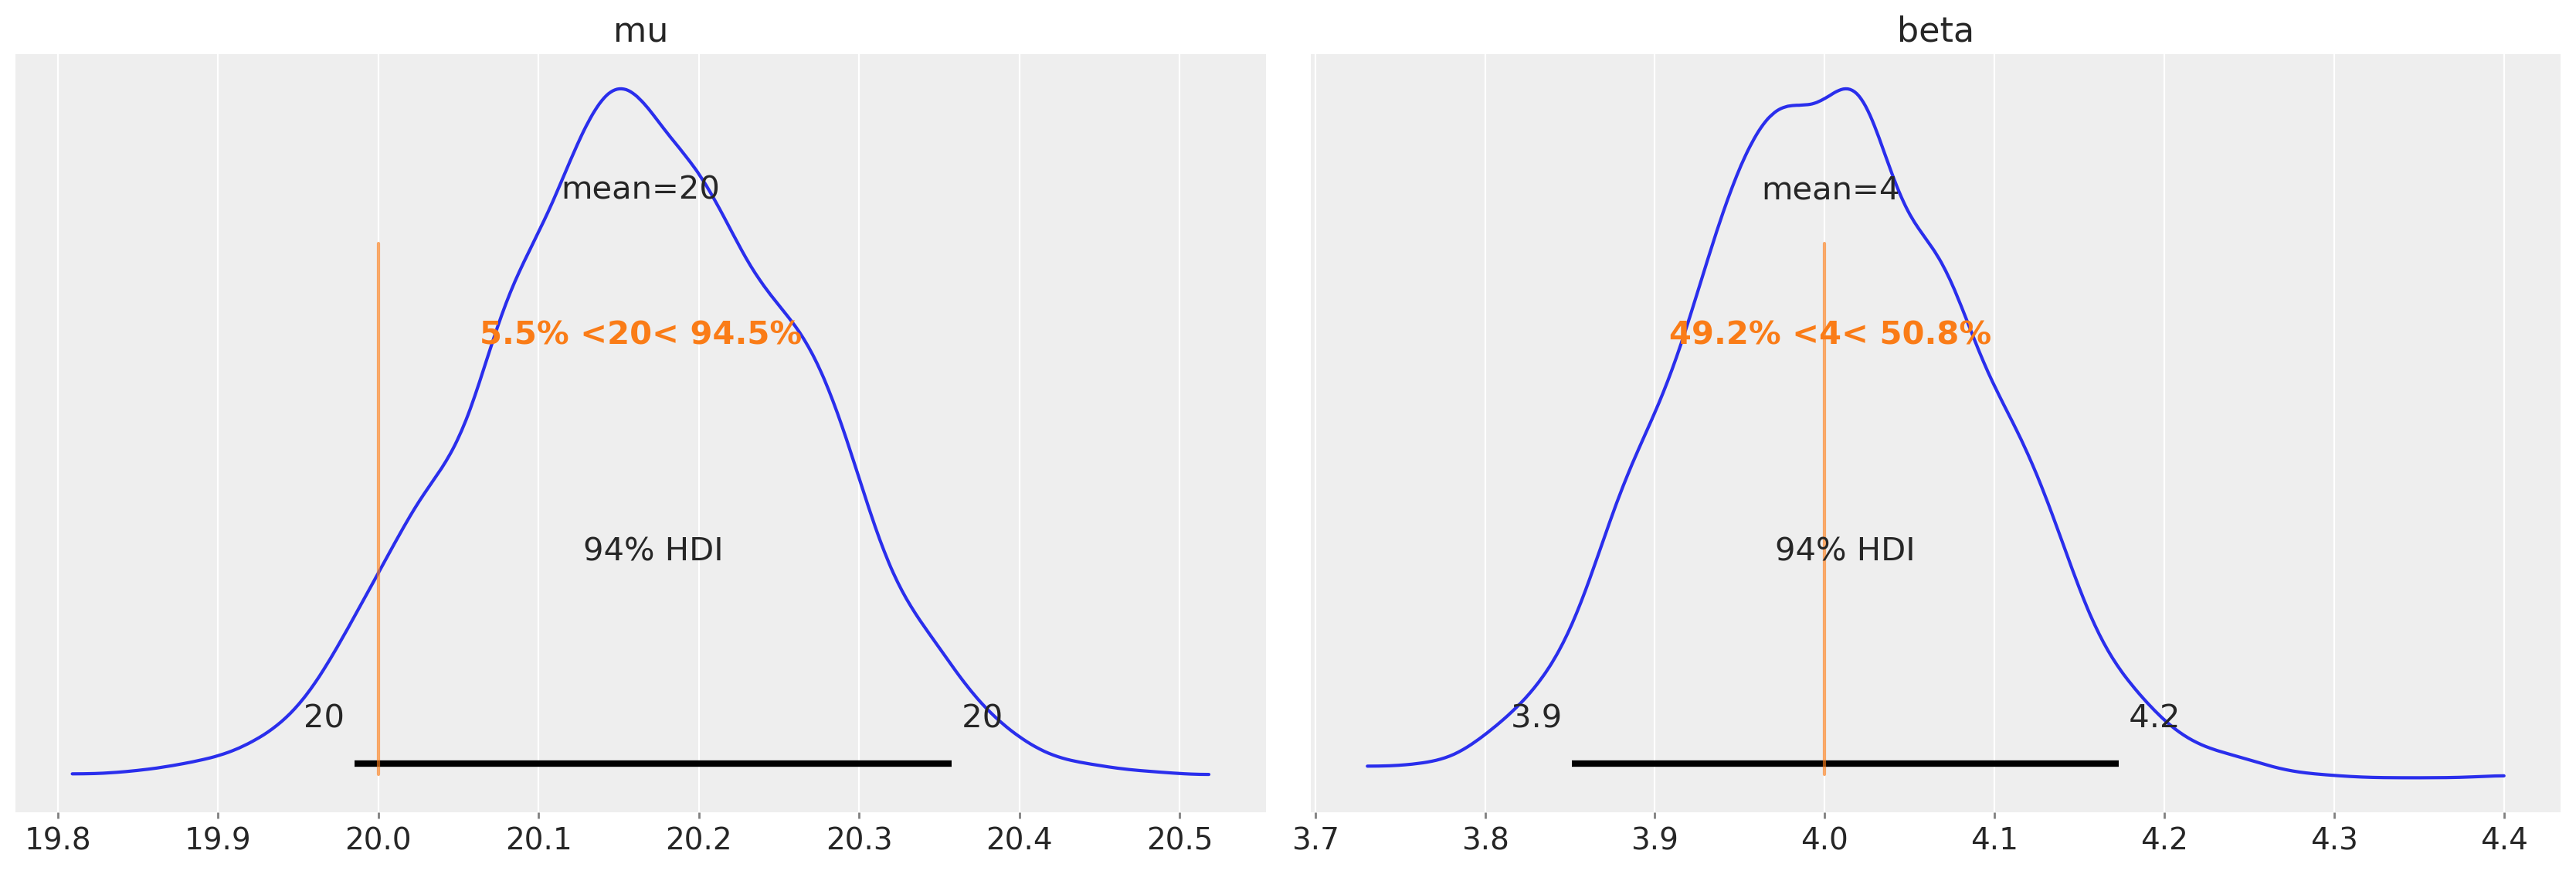

In [63]:
az.plot_posterior(trace6, var_names=["mu", "beta"], ref_val=[true_mu, true_beta]);

We can see that we were able to do a good job of recovering the known parameters of the underlying BMI population.

If we were interested in testing whether there were any differences in the BMI distributions in Study 1 and Study 2, then we could simply take the model in Example 6 and adapt it to operate with our desired target distribution, just like we did in this example.

## Conclusions

As you can see, this method for estimating known parameters of Gaussian and non-Gaussian distributions works pretty well.
While these examples have been applied to synthetic data, doing these kinds of parameter recovery studies is crucial. If we tried to recover population level parameters from counts and could _not_ do it when we know the ground truth, then this would indicate the approach is not trustworthy. But the various parameter recovery examples demonstrate that we _can_ in fact accurately recover population level parameters from binned, and _differently_ binned data.

A key technical point to note here is that when we pass in the observed counts,
they ought to be in the exact CDF order.
Not shown here are experiments where we scrambled the counts' order;
there, the estimation of underlying distribution parameters were incorrect.

We have presented a range of different examples here which makes clear that the general approach can be adapted easily to the particular situation or research questions being faced. These approaches should easily be adaptable to novel but related data science situations.

## Authors
* Authored by [Eric Ma](https://github.com/ericmjl) and [Benjamin T. Vincent](https://github.com/drbenvincent) in September, 2021 ([pymc-examples#229](https://github.com/pymc-devs/pymc-examples/pull/229))
* Updated to run in PyMC v4 by Fernando Irarrazaval in June 2022 ([pymc-examples#366](https://github.com/pymc-devs/pymc-examples/pull/366))

## Watermark

In [64]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aeppl,xarray

Last updated: Sat Jun 04 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

aeppl : 0.0.27
xarray: 2022.3.0

pandas    : 1.4.2
seaborn   : 0.11.2
matplotlib: 3.5.1
pymc      : 4.0.0b6
arviz     : 0.12.1
numpy     : 1.22.4
aesara    : 2.5.1

Watermark: 2.3.1



:::{include} ../page_footer.md
:::